In [1]:
%load_ext autoreload
%autoreload 2
from renyi import renyi_sim_entropy, rbf_kernel
from sklearn.neighbors import NearestNeighbors
from utils import batch_pdist
import utils
import torch
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import scipy.stats as ss
from scipy.signal import savgol_filter
from umap import UMAP

VSMALL_SIZE = 9
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 18

from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.sans-serif'] = ['Lucida Grande']

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=VSMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title
matplotlib.rcParams.update({'font.size': 18})

In [2]:
from gan_entropy_eval.readers.mnist import ImageReader

In [3]:
def rbf_kernel(X, Y, sigmas=[1.], p=2, degree=2):
    pdist = utils.batch_pdist(X, Y, p)
    res = torch.zeros_like(pdist)
    for sigma in sigmas:
        res += torch.exp(- (pdist/sigma)**degree)
    return res / len(sigmas)

def rbf_kernel_pdist(pdist, sigmas=[1.], p=2, degree=2):
    res = torch.zeros_like(pdist)
    for sigma in sigmas:
        res += torch.exp(- (pdist/sigma)**degree)
    return res / len(sigmas)

def batch_pdist(X, Y, p=2):
    return torch.norm(X[..., None, :] - Y[..., None, :, :], p=p, dim=-1)

def birthday(dists, eps=1.):
    """
    Take in a set of distances and a ball radius and estimate the size of the support.
    We use the fact that in a perfect case of drawing m samples with replacement from a uniform discrete
    distribution of support n the expected number of collisions is c = (m^2 - m)/n, so we can estimate n as
    \hat(n) = (m^2 - m)/c.
    
    This approach is dramatically faster than the traditional birthday paradox approach, which is to estimate the
    batch size required to have a 50% chance of a collision; that approach makes sense when human input is required,
    but it does not when comparisons are automatic and counting the number of collisions is trivial.
    """
    dists = dists + 10*eps*torch.eye(dists.shape[0], device=dists.device) # Mask the diagonal
    collisions = (dists < eps)
    collisions = collisions.float().sum()
    if collisions < 1:
        collisions = collisions + 1
    count = (dists.shape[0] **2 - dists.shape[0])/collisions
    return count.item()
    
    
def derivative(x, scale, deriv_number=2, smooth=True):
    for i in range(deriv_number):
        x = np.gradient(x)/scale
        if smooth and i==0:
            x = savgol_filter(x, 11, 1)
    return x

## MNIST

In [4]:
reader = ImageReader("./data", "mnist")

In [5]:
iterator = reader.iter_batches("train", 100000, partial_batching=True)
data = []
for batch in iterator:
    data.append(batch)
labels = data[0][1]
data = data[0][0]
flat_data = data.flatten(1, -1).numpy()

In [6]:
reducer = UMAP(n_components=2, min_dist=0.001, metric="cosine")
umap_data = reducer.fit_transform(flat_data[:])

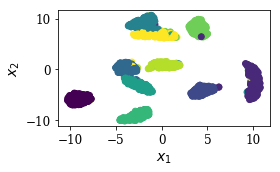

In [7]:
plt.figure(figsize=(4, 2.5))
plt.scatter(umap_data[:2000, 0], umap_data[:2000, 1], c=labels[:2000])
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.tight_layout()
plt.savefig("reduced_mnist.pdf")
plt.show()

In [8]:
umap_data = torch.tensor(umap_data)

In [9]:
pdists = batch_pdist(umap_data[:1000], umap_data[:1000], 2)
raw_pdists = batch_pdist(torch.tensor(flat_data[:1000]), torch.tensor(flat_data[:1000]), 1)

In [10]:
sigmas = np.linspace(1, 10, 100)
entropies = []
alpha = 1
for j, sigma in enumerate(sigmas):
    k = rbf_kernel_pdist(pdists, sigmas=[sigma], degree=2)
    entropy = renyi_sim_entropy(k, torch.ones(k.shape[0])/k.shape[0], alpha=alpha).item()
    entropies.append(entropy)

In [11]:
eps = np.linspace(1., 10, 100)
counts = []
alpha = 1
for j, sigma in enumerate(eps):
#     k = rbf_kernel_pdist(pdists, sigmas=[sigma], degree=2)
    count = birthday(pdists, eps=sigma)
    counts.append(count)

### Plotting

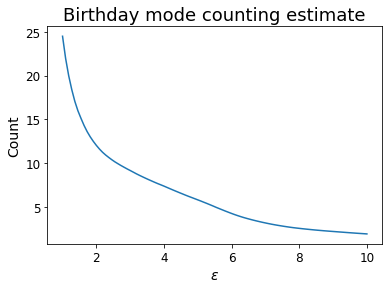

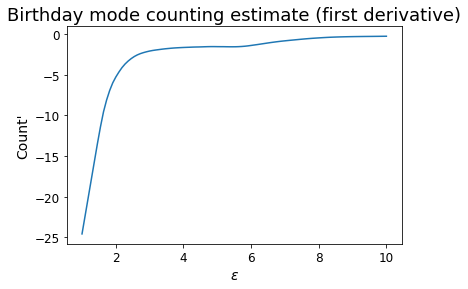

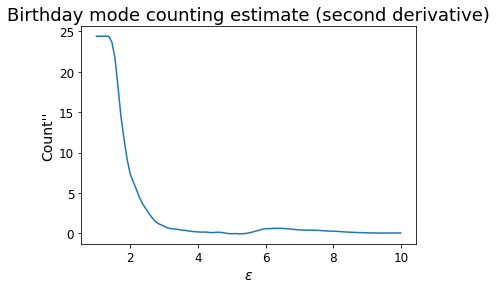

In [682]:
plt.figure()
plt.plot(eps, counts, label="Birthday Estimate")
# plt.yscale("log")
plt.title("Birthday mode counting estimate")
plt.xlabel(r"$\epsilon$")
plt.ylabel("Count")
plt.show()

plt.figure()
plt.plot(eps, derivative(counts, eps[1]-eps[0], 1), label="Birthday Estimate")
# plt.yscale("log")
plt.title("Birthday mode counting estimate (first derivative)")
plt.xlabel(r"$\epsilon$")
plt.ylabel("Count\'")
plt.show()

plt.figure()
plt.plot(eps, derivative(counts, eps[1]-eps[0], 2), label="Birthday Estimate")
# plt.yscale("log")
plt.title("Birthday mode counting estimate (second derivative)")
plt.xlabel(r"$\epsilon$")
plt.ylabel("Count\'\'")
plt.show()

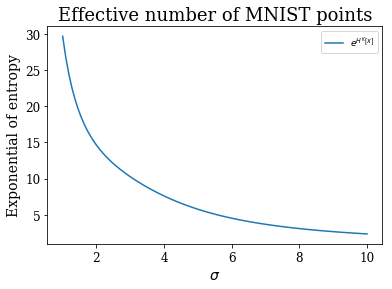

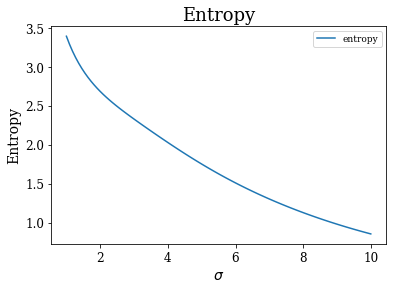

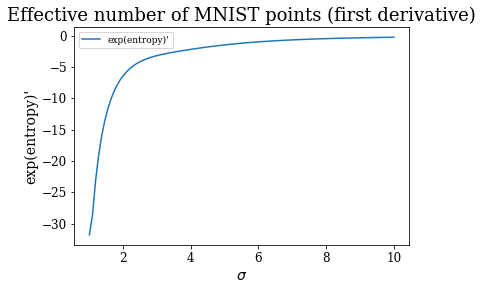

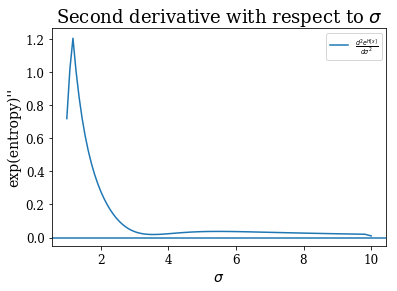

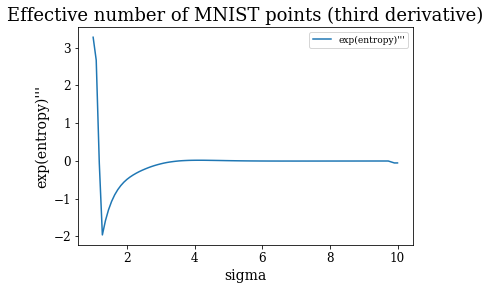

In [779]:
plt.figure()
plt.plot(sigmas, np.exp(entropies), label=r"$e^{H^K[x]}$")
plt.xlabel(r"$\sigma$")
plt.ylabel("Exponential of entropy")
# plt.axhline(10)
plt.legend()
plt.title("Effective number of MNIST points")
# plt.xlim(10, 20)
# plt.ylim(0, 4)
plt.show()

plt.figure()
plt.plot(sigmas, entropies, label="entropy")
plt.xlabel(r"$\sigma$")
plt.ylabel("Entropy")
plt.legend()
plt.title("Entropy")
# plt.xlim(10, 20)
# plt.ylim(0, 4)
plt.show()

plt.figure()
plt.plot(sigmas, derivative(np.exp(entropies), sigmas[1]-sigmas[0], 1, smooth=False), label="exp(entropy)\'")
plt.xlabel(r"$\sigma$")
plt.ylabel("exp(entropy)\'")
plt.title("Effective number of MNIST points (first derivative)")
plt.legend()
# plt.xlim(10, 20)
# plt.ylim(0, 4)
plt.show()


plt.figure()
plt.plot(sigmas, derivative((entropies), sigmas[1]-sigmas[0], 2, smooth=False), label=r"$\frac{d^2 e^{H[x]}}{d \sigma ^2}$")
plt.xlabel(r"$\sigma$")
plt.axhline(0)
plt.ylabel("exp(entropy)\'\'")
plt.title(r"Second derivative with respect to $\sigma$")
plt.legend()
# plt.xlim(10, 20)
# plt.ylim(0, 4)
plt.show()



plt.figure()
plt.plot(sigmas, derivative((entropies), sigmas[1]-sigmas[0], 3, smooth=False), label="exp(entropy)\'\'\'")
plt.xlabel("sigma")
plt.ylabel("exp(entropy)\'\'\'")
plt.title("Effective number of MNIST points (third derivative)")
plt.legend()
# plt.xlim(10, 20)
# plt.ylim(0, 4)
plt.show()

In [308]:
derivative(np.exp(entropies), sigmas[1]-sigmas[0], 2, smooth=False)

array([3.45419358e+01, 4.73093520e+01, 5.24630706e+01, 3.95300049e+01,
       3.03954948e+01, 2.37799399e+01, 1.88803586e+01, 1.51794282e+01,
       1.23359703e+01, 1.01166837e+01, 8.35930511e+00, 6.95194362e+00,
       5.81275789e+00, 4.88295199e+00, 4.12081953e+00, 3.49227391e+00,
       2.97363731e+00, 2.54699361e+00, 2.19622809e+00, 1.90910719e+00,
       1.67617668e+00, 1.48853405e+00, 1.33735427e+00, 1.21673553e+00,
       1.12228880e+00, 1.04783388e+00, 9.88997436e-01, 9.43120935e-01,
       9.06661294e-01, 8.77403289e-01, 8.53455863e-01, 8.32852148e-01,
       8.14509211e-01, 7.97468172e-01, 7.81051677e-01, 7.64718180e-01,
       7.48093220e-01, 7.30947786e-01, 7.13172853e-01, 6.94897936e-01,
       6.76039427e-01, 6.56610480e-01, 6.36948128e-01, 6.16946292e-01,
       5.96609574e-01, 5.76419010e-01, 5.56292079e-01, 5.36215079e-01,
       5.16393285e-01, 4.96995916e-01, 4.78020792e-01, 4.59381587e-01,
       4.41294478e-01, 4.23802083e-01, 4.06883795e-01, 3.90508916e-01,
      

8.849903636545012


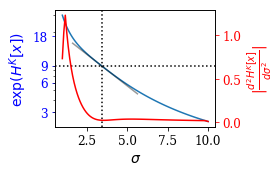

In [69]:
first_below_thresh = np.arange(len(entropies))[np.abs(derivative((entropies),
                                                                 sigmas[1]-sigmas[0], 3, smooth=False)) < .01][0]
vertical = sigmas[first_below_thresh]
estimated_count = np.exp(entropies)[first_below_thresh]
print((estimated_count))

line_y = sigmas*derivative((entropies), sigmas[1]-sigmas[0], 1, smooth=False)[first_below_thresh]
line_y = line_y - line_y[first_below_thresh] + (entropies)[first_below_thresh]
line_y = np.exp(line_y)

fig, ax1 = plt.subplots(figsize=(4, 2.5))
# t = np.arange(0.01, 10.0, 0.01)
# s1 = np.exp(t)
ax1.plot(sigmas, np.exp(entropies), label=r"$e^{H^K[x]}$")
ax1.set_yscale("log")
ticker = matplotlib.ticker.ScalarFormatter()#LogFormatter()
ax1.yaxis.set_major_formatter(ticker)
ax1.set_yticks([3, 6, 9, 18])
ax1.set_xlabel(r'$\sigma$')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel(r"$\exp(H^K[x])$", color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
# s2 = np.sin(2 * np.pi * t)
ax2.plot(sigmas, np.abs(derivative((entropies), sigmas[1]-sigmas[0], 2, smooth=False)), label=r"$|\frac{d^2 e^{H[x]}}{d \sigma ^2}|$", c="r")
ax2.set_ylabel(r"$|\frac{d^2 H^K[x]}{d \sigma ^2}|$", color='r',)
ax2.tick_params('y', colors='r')

ax1.plot(sigmas[first_below_thresh-20:first_below_thresh+25], line_y[first_below_thresh-20:first_below_thresh+25], c="k", linestyle="-", alpha=0.4)

ax1.axhline(estimated_count, color="k", linestyle=":")
ax1.axvline(vertical, color="k", linestyle=":")
# ax2.axhline(0.01, color="k", linestyle=":")
# plt.title("Mode detection for MNIST")
fig.tight_layout()
plt.savefig("mnist_entropy_detection.pdf")
plt.show()

In [766]:
line_y

array([2.6707164 , 2.64997956, 2.62924271, 2.60850587, 2.58776902,
       2.56703218, 2.54629533, 2.52555849, 2.50482164, 2.4840848 ,
       2.46334795, 2.44261111, 2.42187426, 2.40113742, 2.38040057,
       2.35966373, 2.33892688, 2.31819004, 2.29745319, 2.27671635,
       2.2559795 , 2.23524266, 2.21450582, 2.19376897, 2.17303213,
       2.15229528, 2.13155844, 2.11082159, 2.09008475, 2.0693479 ,
       2.04861106, 2.02787421, 2.00713737, 1.98640052, 1.96566368,
       1.94492683, 1.92418999, 1.90345314, 1.8827163 , 1.86197945,
       1.84124261, 1.82050577, 1.79976892, 1.77903208, 1.75829523,
       1.73755839, 1.71682154, 1.6960847 , 1.67534785, 1.65461101,
       1.63387416, 1.61313732, 1.59240047, 1.57166363, 1.55092678,
       1.53018994, 1.50945309, 1.48871625, 1.4679794 , 1.44724256,
       1.42650572, 1.40576887, 1.38503203, 1.36429518, 1.34355834,
       1.32282149, 1.30208465, 1.2813478 , 1.26061096, 1.23987411,
       1.21913727, 1.19840042, 1.17766358, 1.15692673, 1.13618

8.190269470214844


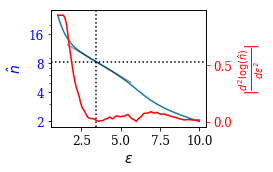

In [64]:
first_below_thresh = np.arange(len(counts))[np.abs(derivative(np.log(counts), eps[1]-eps[0], 2)) < .01][0]
vertical = eps[first_below_thresh]
estimated_count = (counts)[first_below_thresh]
print((estimated_count))

line_y = eps*derivative(np.log(counts), sigmas[1]-sigmas[0], 1, smooth=False)[first_below_thresh]
line_y = line_y - line_y[first_below_thresh] + np.log(counts)[first_below_thresh]

fig, ax1 = plt.subplots(figsize=(4, 2.5))
# t = np.arange(0.01, 10.0, 0.01)
# s1 = np.exp(t)

ax1.set_yscale("log")
ticker = matplotlib.ticker.ScalarFormatter()#LogFormatter()
ax1.yaxis.set_major_formatter(ticker)

ax1.plot(eps, (counts), label=r"$e^{H^K[x]}$")
ax1.set_xlabel(r'$\epsilon$')
ax1.set_yticks([2, 4, 8, 16])
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel(r'$\hat{n}$', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
# s2 = np.sin(2 * np.pi * t)
ax2.plot(eps, np.abs(derivative(np.log(counts), eps[1]-eps[0], 2)), label=r"$\frac{d^2 e^{H[x]}}{d \sigma ^2}$", c="r")
ax2.set_ylabel(r"$|\frac{d^2 \log (\hat{n})}{d \epsilon ^2}|$", color='r',)
ax2.tick_params('y', colors='r')

line_y = np.exp(line_y)
ax1.plot(eps[first_below_thresh-20:first_below_thresh+25], line_y[first_below_thresh-20:first_below_thresh+25], c="k", linestyle="-", alpha=.4)

ax1.axhline(estimated_count, color="k", linestyle=":")
ax1.axvline(vertical, color="k", linestyle=":")
# ax2.axhline(0.01, color="k", linestyle=":")
fig.tight_layout()
# plt.title("Birthday Mode counting for MNIST")
plt.savefig("birthday_mnist.pdf")
plt.show()

## Raw MNIST

In [315]:
sigmas = np.linspace(10, 200, 500)
entropies = []
alpha = 1
for j, sigma in enumerate(sigmas):
    k = rbf_kernel_pdist(raw_pdists, sigmas=[sigma], degree=2)
    entropy = renyi_sim_entropy(k, torch.ones(k.shape[0])/k.shape[0], alpha=alpha).item()
    entropies.append(entropy)

In [316]:
eps = np.linspace(20, 200, 500)
counts = []
alpha = 1
for j, sigma in enumerate(eps):
#     k = rbf_kernel_pdist(pdists, sigmas=[sigma], degree=2)
    count = birthday(raw_pdists, eps=sigma)
    counts.append(count)

### Plotting

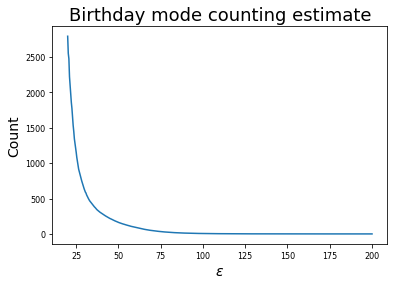

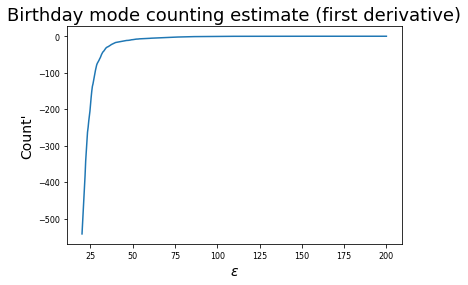

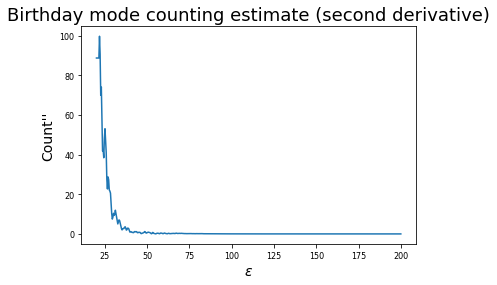

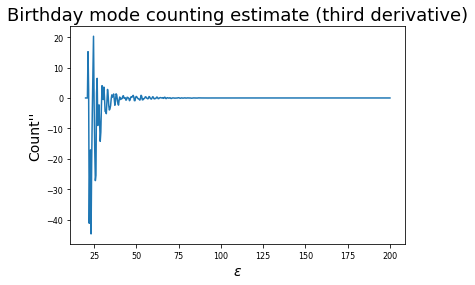

In [317]:
plt.figure()
plt.plot(eps, counts, label="Birthday Estimate")
# plt.yscale("log")
plt.title("Birthday mode counting estimate")
plt.xlabel(r"$\epsilon$")
plt.ylabel("Count")
plt.show()

plt.figure()
plt.plot(eps, derivative(counts, eps[1]-eps[0], 1), label="Birthday Estimate")
# plt.yscale("log")
plt.title("Birthday mode counting estimate (first derivative)")
plt.xlabel(r"$\epsilon$")
plt.ylabel("Count\'")
plt.show()

plt.figure()
plt.plot(eps, derivative(counts, eps[1]-eps[0], 2), label="Birthday Estimate")
# plt.yscale("log")
plt.title("Birthday mode counting estimate (second derivative)")
plt.xlabel(r"$\epsilon$")
plt.ylabel("Count\'\'")
plt.show()


plt.figure()
plt.plot(eps, derivative(counts, eps[1]-eps[0], 3), label="Birthday Estimate")
# plt.yscale("log")
plt.title("Birthday mode counting estimate (third derivative)")
plt.xlabel(r"$\epsilon$")
plt.ylabel("Count\'\'")
plt.show()

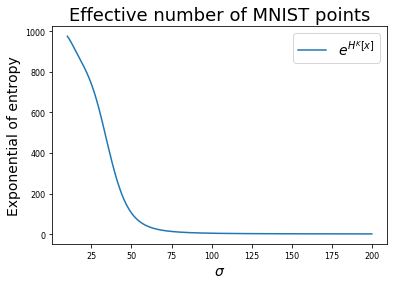

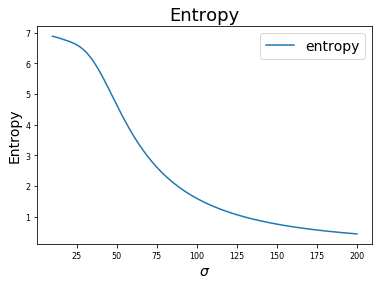

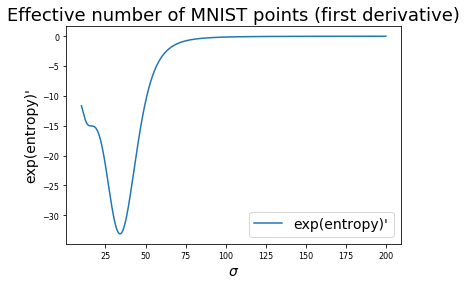

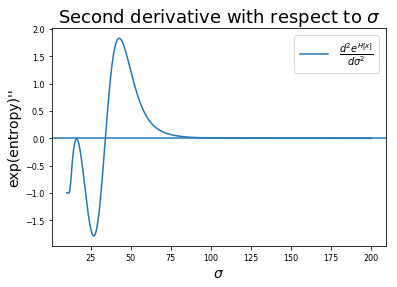

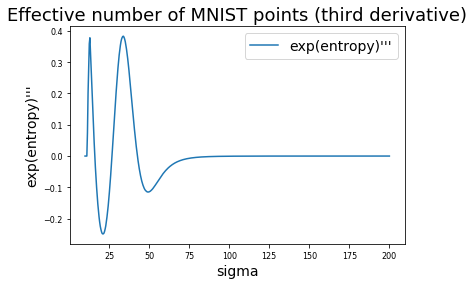

In [318]:
plt.figure()
plt.plot(sigmas, np.exp(entropies), label=r"$e^{H^K[x]}$")
plt.xlabel(r"$\sigma$")
plt.ylabel("Exponential of entropy")
# plt.axhline(10)
plt.legend()
plt.title("Effective number of MNIST points")
# plt.xlim(10, 20)
# plt.ylim(0, 4)
plt.show()

plt.figure()
plt.plot(sigmas, entropies, label="entropy")
plt.xlabel(r"$\sigma$")
plt.ylabel("Entropy")
plt.legend()
plt.title("Entropy")
# plt.xlim(10, 20)
# plt.ylim(0, 4)
plt.show()

plt.figure()
plt.plot(sigmas, derivative(np.exp(entropies), sigmas[1]-sigmas[0], 1), label="exp(entropy)\'")
plt.xlabel(r"$\sigma$")
plt.ylabel("exp(entropy)\'")
plt.title("Effective number of MNIST points (first derivative)")
plt.legend()
# plt.xlim(10, 20)
# plt.ylim(0, 4)
plt.show()


plt.figure()
plt.plot(sigmas, derivative(np.exp(entropies), sigmas[1]-sigmas[0], 2), label=r"$\frac{d^2 e^{H[x]}}{d \sigma ^2}$")
plt.xlabel(r"$\sigma$")
plt.axhline(0)
plt.ylabel("exp(entropy)\'\'")
plt.title(r"Second derivative with respect to $\sigma$")
plt.legend()
# plt.xlim(10, 20)
# plt.ylim(0, 4)
plt.show()



plt.figure()
plt.plot(sigmas, derivative(np.exp(entropies), sigmas[1]-sigmas[0], 3), label="exp(entropy)\'\'\'")
plt.xlabel("sigma")
plt.ylabel("exp(entropy)\'\'\'")
plt.title("Effective number of MNIST points (third derivative)")
plt.legend()
# plt.xlim(10, 20)
# plt.ylim(0, 4)
plt.show()

52.90461634648931


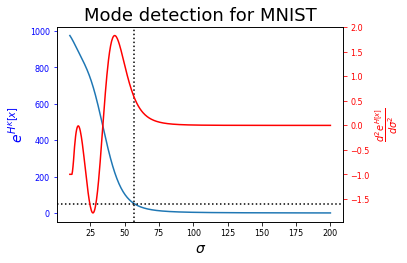

In [319]:
converged = (derivative(np.exp(entropies), sigmas[1]-sigmas[0], 2, smooth=False) < 1.)*\
            (np.abs(derivative(np.exp(entropies), sigmas[1]-sigmas[0], 1, smooth=False)) < 5)

first_below_thresh = np.arange(len(entropies))[converged][0]
vertical = sigmas[first_below_thresh]
estimated_count = np.exp(entropies)[first_below_thresh]
print(estimated_count)

fig, ax1 = plt.subplots()
# t = np.arange(0.01, 10.0, 0.01)
# s1 = np.exp(t)
ax1.plot(sigmas, np.exp(entropies), label=r"$e^{H^K[x]}$")
ax1.set_xlabel(r'$\sigma$')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel(r"$e^{H^K[x]}$", color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
# s2 = np.sin(2 * np.pi * t)
ax2.plot(sigmas, (derivative(np.exp(entropies), sigmas[1]-sigmas[0], 2)), label=r"$\frac{d^2 e^{H[x]}}{d \sigma ^2}$", c="r")
ax2.set_ylabel(r"$\frac{d^2 e^{H[x]}}{d \sigma ^2}$", color='r',)
ax2.tick_params('y', colors='r')

ax1.axhline(estimated_count, color="k", linestyle=":")
ax1.axvline(vertical, color="k", linestyle=":")
# ax2.axhline(0.01, color="k", linestyle=":")
plt.title("Mode detection for MNIST")
fig.tight_layout()
plt.savefig("mnist_detection.pdf")
plt.show()

14.55334758758545


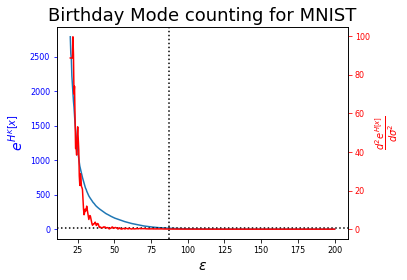

In [321]:
converged = (derivative(counts, eps[1]-eps[0], 2) < 1.)*\
            (np.abs(derivative(counts, eps[1]-eps[0], 1)) < 1)

first_below_thresh = np.arange(len(counts))[converged][0]
vertical = eps[first_below_thresh]
estimated_count = counts[first_below_thresh]
print(estimated_count)
fig, ax1 = plt.subplots()
# t = np.arange(0.01, 10.0, 0.01)
# s1 = np.exp(t)
ax1.plot(eps, counts, label=r"$e^{H^K[x]}$")
ax1.set_xlabel(r'$\epsilon$')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel(r"$e^{H^K[x]}$", color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
# s2 = np.sin(2 * np.pi * t)
ax2.plot(eps, derivative(counts, eps[1]-eps[0], 2), label=r"$\frac{d^2 e^{H[x]}}{d \sigma ^2}$", c="r")
ax2.set_ylabel(r"$\frac{d^2 e^{H[x]}}{d \sigma ^2}$", color='r',)
ax2.tick_params('y', colors='r')

ax1.axhline(estimated_count, color="k", linestyle=":")
ax1.axvline(vertical, color="k", linestyle=":")
# ax2.axhline(0.01, color="k", linestyle=":")
fig.tight_layout()
plt.title("Birthday Mode counting for MNIST")
plt.savefig("mog_detection.pdf")
plt.show()

## Mixture of Gaussians

In [71]:
n = 1000
# Parameters of the mixture components
norm_means = np.array([[5, 1],
                        [-1, -5],
                        [-9, 3],
                        [25, 18],
                        [-10, 15],
                        [15, -9]])

norm_covs = [1*np.eye(2) for i in range(norm_means.shape[0])]
n_components = norm_means.shape[0]
# Weight of each component, in this case all of them are 1/3
weights = np.ones(len(norm_means), dtype=np.float64) / len(norm_means)
# A stream of indices from which to choose the component
mixture_idx = np.random.choice(len(weights), size=n, replace=True, p=weights)
# y is the mixture sample
data = np.stack([np.random.multivariate_normal(norm_means[i], norm_covs[i]) for i in mixture_idx], 0)


In [72]:
gmm_pdists = utils.batch_pdist(torch.tensor(data), torch.tensor(data), 1).float()

In [73]:
sigmas = np.linspace(1.5, 15, 100)
# sigmas = np.exp(ks)
entropies = []
for sigma in sigmas:
    k = rbf_kernel_pdist(gmm_pdists, sigmas=[sigma], degree=10)
#     k = 1 / (1 + pdists/sigma)**2
    entropy = renyi_sim_entropy(k, torch.ones(k.shape[0])/k.shape[0]).item()
    entropies.append(entropy)

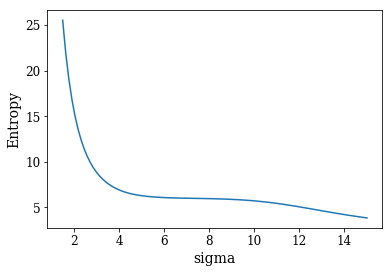

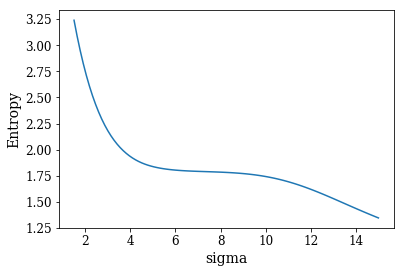

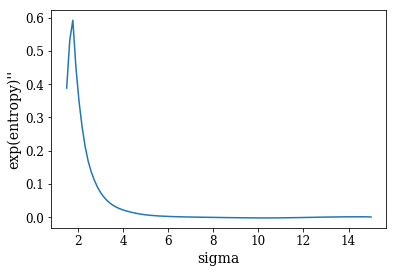

In [74]:
plt.figure()
plt.plot(sigmas, np.exp(entropies))
plt.xlabel("sigma")
plt.ylabel("Entropy")
plt.show()

plt.figure()
plt.plot(sigmas, (entropies))
plt.xlabel("sigma")
plt.ylabel("Entropy")
plt.show()


plt.figure()
plt.plot(sigmas, np.gradient(np.gradient(np.exp(entropies))))
plt.xlabel("sigma")
plt.ylabel("exp(entropy)\'\'")
plt.show()

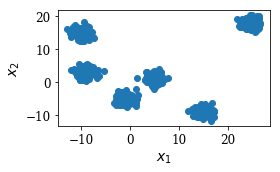

In [75]:
plt.figure(figsize=(4, 2.5))
plt.scatter(data[:, 0], data[:, 1])
# plt.title("Mixture of Gaussians")
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.tight_layout()
plt.savefig("mixture.pdf")
plt.show()

5.987891640867108


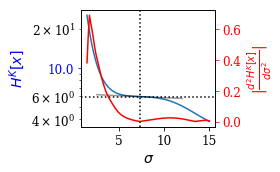

In [123]:
first_below_thresh = np.arange(len(entropies))[np.abs(derivative((entropies),
                                                                 sigmas[1]-sigmas[0], 2, smooth=False)) < .001][0]
vertical = sigmas[first_below_thresh]
estimated_count = np.exp(entropies)[first_below_thresh]
print((estimated_count))

line_y = sigmas*derivative((entropies), sigmas[1]-sigmas[0], 1, smooth=False)[first_below_thresh]
line_y = line_y - line_y[first_below_thresh] + (entropies)[first_below_thresh]

fig, ax1 = plt.subplots(figsize=(4, 2.5))
ax2 = ax1.twinx()

ticker = matplotlib.ticker.ScalarFormatter()
ax1.set_yscale("log")
ax1.yaxis.set_major_formatter(ticker)

ax1.plot(sigmas, np.exp(entropies), label=r"$e^{H^K[x]}$")
ax1.set_xlabel(r'$\sigma$')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel(r"$H^K[x]$", color='b')
ax1.tick_params('y', colors='b')
# ax1.set_yticks([4, 6, 10, 20])


ax2.plot(sigmas, np.abs(derivative((entropies), sigmas[1]-sigmas[0], 2, smooth=False)), label=r"$|\frac{d^2 e^{H[x]}}{d \sigma ^2}|$", c="r")
ax2.set_ylabel(r"$|\frac{d^2 H^K[x]}{d \sigma ^2}|$", color='r',)
ax2.tick_params('y', colors='r')

line_y = np.exp(line_y)
ax1.plot(sigmas[first_below_thresh-35:first_below_thresh+35], line_y[first_below_thresh-35:first_below_thresh+35], c="k", linestyle="-", alpha=0.4)

ax1.axhline(estimated_count, color="k", linestyle=":")
ax1.axvline(vertical, color="k", linestyle=":")


fig.tight_layout()
plt.savefig("mog_entropy_detection.pdf")
plt.show()

5.982066912025773


<Figure size 432x288 with 0 Axes>

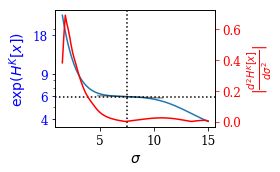

In [136]:
first_below_thresh = np.arange(len(entropies))[np.abs(derivative((entropies),
                                                                 sigmas[1]-sigmas[0], 3, smooth=False)) < .01][0]
vertical = sigmas[first_below_thresh]
estimated_count = np.exp(entropies)[first_below_thresh]
print((estimated_count))

line_y = sigmas*derivative((entropies), sigmas[1]-sigmas[0], 1, smooth=False)[first_below_thresh]
line_y = line_y - line_y[first_below_thresh] + (entropies)[first_below_thresh]
line_y = np.exp(line_y)

plt.clf()
# plt.figure()
fig, ax1 = plt.subplots(figsize=(4, 2.5))
# t = np.arange(0.01, 10.0, 0.01)
# s1 = np.exp(t)
ax1.plot(sigmas, np.exp(entropies), label=r"$e^{H^K[x]}$")
ax1.set_yscale("log")
ax1.set_yticks([])
ticker = matplotlib.ticker.ScalarFormatter()#LogFormatter()
ax1.yaxis.set_major_formatter(ticker)
ax1.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax1.set_yticks([4, 6, 9, 18])
ax1.set_xlabel(r'$\sigma$')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel(r"$\exp(H^K[x])$", color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
# s2 = np.sin(2 * np.pi * t)
ax2.plot(sigmas, np.abs(derivative((entropies), sigmas[1]-sigmas[0], 2, smooth=False)), label=r"$|\frac{d^2 e^{H[x]}}{d \sigma ^2}|$", c="r")
ax2.set_ylabel(r"$|\frac{d^2 H^K[x]}{d \sigma ^2}|$", color='r',)
ax2.tick_params('y', colors='r')

ax1.plot(sigmas[first_below_thresh-20:first_below_thresh+25], line_y[first_below_thresh-20:first_below_thresh+25], c="k", linestyle="-", alpha=0.4)

ax1.axhline(estimated_count, color="k", linestyle=":")
ax1.axvline(vertical, color="k", linestyle=":")
# ax2.axhline(0.01, color="k", linestyle=":")
# plt.title("Mode detection for MNIST")
fig.tight_layout()
plt.savefig("mog_entropy_detection.pdf")
plt.show()

In [141]:
eps = np.linspace(1, 15, 100)
counts = []
alpha = 1
for j, cutoff in enumerate(eps):
#     k = rbf_kernel_pdist(pdists, sigmas=[sigma], degree=2)
    count = birthday(gmm_pdists, eps=cutoff)
    print(count)
    counts.append(count)

41.366458892822266
32.435062408447266
26.354665756225586
22.053955078125
18.88825798034668
16.47970962524414
14.563531875610352
13.058823585510254
11.85222053527832
10.888757705688477
10.101112365722656
9.455571174621582
8.908031463623047
8.446916580200195
8.06686019897461
7.748871803283691
7.480008602142334
7.2495317459106445
7.056679725646973
6.887375354766846
6.747173309326172
6.622823715209961
6.513659477233887
6.427413463592529
6.350356578826904
6.288397789001465
6.240161895751953
6.198655128479004
6.167580604553223
6.136665344238281
6.111362457275391
6.090795040130615
6.072431564331055
6.057629108428955
6.045312404632568
6.035378456115723
6.026712894439697
6.020683765411377
6.015028476715088
6.009456157684326
6.005988121032715
6.002451419830322
6.0
5.996758460998535
5.993736267089844
5.9896392822265625
5.986337661743164
5.981749534606934
5.977097034454346
5.970952033996582
5.964463710784912
5.956640243530273
5.947632312774658
5.937804698944092
5.925548076629639
5.910892963409424


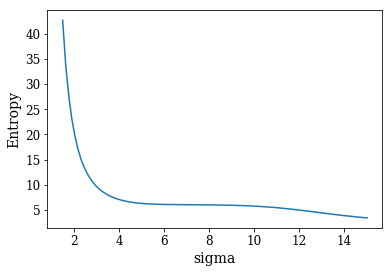

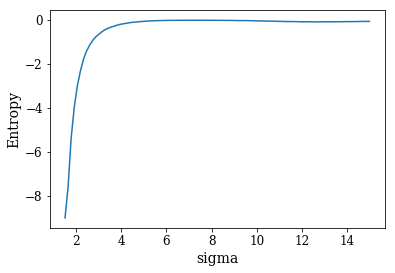

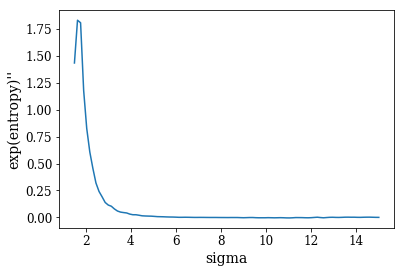

In [881]:
plt.figure()
plt.plot(sigmas, gmm_counts)
plt.xlabel("sigma")
plt.ylabel("Entropy")
plt.show()

plt.figure()
plt.plot(sigmas, np.gradient(gmm_counts))
plt.xlabel("sigma")
plt.ylabel("Entropy")
plt.show()


plt.figure()
plt.plot(sigmas, np.gradient(np.gradient(gmm_counts)))
plt.xlabel("sigma")
plt.ylabel("exp(entropy)\'\'")
plt.show()

6.015028476715088


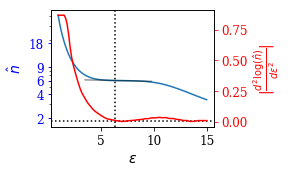

In [145]:
first_below_thresh = np.arange(len(counts))[np.abs(derivative(np.log(counts), eps[1]-eps[0], 2)) < .01][0]
vertical = eps[first_below_thresh]
estimated_count = np.log(counts)[first_below_thresh]
print(np.exp(estimated_count))

line_y = eps*derivative(np.log(counts), sigmas[1]-sigmas[0], 1, smooth=False)[first_below_thresh]
line_y = line_y - line_y[first_below_thresh] + np.log(counts)[first_below_thresh]

fig, ax1 = plt.subplots(figsize=(4, 2.5))
# t = np.arange(0.01, 10.0, 0.01)
# s1 = np.exp(t)
ax1.plot(eps, (counts), label=r"$e^{H^K[x]}$")
ax1.set_xlabel(r'$\epsilon$')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel(r'$\hat{n}$', color='b')
ax1.tick_params('y', colors='b')

ax1.set_yscale("log")
ax1.set_yticks([])
ticker = matplotlib.ticker.ScalarFormatter()#LogFormatter()
ax1.yaxis.set_major_formatter(ticker)
ax1.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax1.set_yticks([2, 4, 6, 9, 18])

ax2 = ax1.twinx()
# s2 = np.sin(2 * np.pi * t)
ax2.plot(eps, np.abs(derivative(np.log(counts), eps[1]-eps[0], 2)), label=r"$\frac{d^2 e^{H[x]}}{d \sigma ^2}$", c="r")
ax2.set_ylabel(r"$|\frac{d^2 \log (\hat{n})}{d \epsilon ^2}|$", color='r',)
ax2.tick_params('y', colors='r')

line_y = np.exp(line_y)
ax1.plot(eps[first_below_thresh-20:first_below_thresh+25], line_y[first_below_thresh-20:first_below_thresh+25], c="k", linestyle="-", alpha=.4)

ax1.axhline(estimated_count, color="k", linestyle=":")
ax1.axvline(vertical, color="k", linestyle=":")
# ax2.axhline(0.01, color="k", linestyle=":")
fig.tight_layout()
plt.savefig("birthday_mog.pdf")
plt.show()

## Mixture of Gaussians Progression

In [865]:
def sequential_samples(means, covs, n):
    samples = []
    for i in range(means.shape[0]):
        if i == 0:
            mixture_idx = np.zeros(n, dtype="int32")
        else:
            mixture_idx = np.random.choice(i+1, size=n, replace=True)
        data = np.stack([np.random.multivariate_normal(norm_means[i], norm_covs[i]) for i in mixture_idx], 0)
        samples.append(data)
        
    return samples


def progressive_plot(means, covs, n=1000):
    samples = sequential_samples(means, covs, n)
    entropy_estimates = []
    birthday_estimates = []
    for sample in samples:
        dists = batch_pdist(torch.tensor(sample), torch.tensor(sample), 2).float()
        entropy_estimate = get_entropy_estimate(dists)
        birthday_estimate = get_birthday_estimate(dists)
        entropy_estimates.append(entropy_estimate)
        birthday_estimates.append(birthday_estimate)

    
    return entropy_estimates, birthday_estimates, samples
    
def get_birthday_estimate(dists, threshold=.01, eps_range=(.1, 25), n_points=100, d1_threshold=25):
    epsilons = np.linspace(eps_range[0], eps_range[1], n_points)
    counts = [birthday(dists, eps) for eps in epsilons]
    d1 = derivative(np.log(counts), epsilons[1]-epsilons[0], 1, smooth=True)
    d2 = derivative(np.log(counts), epsilons[1]-epsilons[0], 2, smooth=True)

    mask = (np.abs(d1) < d1_threshold) * (np.abs(d2) < threshold)
    first_below = np.arange(n_points)[mask][0]
    return counts[first_below]


def get_entropy_estimate(dists, threshold=.05, sigma_range=(.1, 25), n_points=100, alpha=1, d1_threshold=25):
    sigmas = np.linspace(sigma_range[0], sigma_range[1], n_points)

    entropies = []

    for j, sigma in enumerate(sigmas):
        k = rbf_kernel_pdist(dists, sigmas=[sigma], degree=2)
        entropy = renyi_sim_entropy(k, torch.ones(k.shape[0]) / k.shape[0], alpha=alpha).item()
        entropies.append(entropy)

    d1 = derivative(entropies, sigmas[1] - sigmas[0], 1, smooth=False)
    d2 = derivative(entropies, sigmas[1] - sigmas[0], 2, smooth=False)

    mask = (np.abs(d1) < d1_threshold) * (np.abs(d2) < threshold)
    first_below = np.arange(n_points)[mask][0]
    
    vertical = sigmas[first_below]
    estimated_count = (entropies)[first_below]
    print(np.exp(estimated_count), d2[first_below])

    line_y = sigmas*derivative((entropies), sigmas[1]-sigmas[0], 1, smooth=False)[first_below]
    line_y = line_y - line_y[first_below] + (entropies)[first_below]

    fig, ax1 = plt.subplots(figsize=(4, 2.5))
    # t = np.arange(0.01, 10.0, 0.01)
    # s1 = np.exp(t)
    ax1.plot(sigmas, (entropies), label=r"$e^{H^K[x]}$")
    ax1.set_xlabel(r'$\sigma$')
    # Make the y-axis label, ticks and tick labels match the line color.
    ax1.set_ylabel(r"$H^K[x]$", color='b')
    ax1.tick_params('y', colors='b')

    ax2 = ax1.twinx()
    # s2 = np.sin(2 * np.pi * t)
    ax2.plot(sigmas, np.abs(derivative((entropies), sigmas[1]-sigmas[0], 2, smooth=False)), label=r"$|\frac{d^2 e^{H[x]}}{d \sigma ^2}|$", c="r")
    ax2.set_ylabel(r"$|\frac{d^2 H^K[x]}{d \sigma ^2}|$", color='r',)
    ax2.tick_params('y', colors='r')

    ax1.plot(sigmas[first_below-35:first_below+35], line_y[first_below-35:first_below+35], c="k", linestyle="-", alpha=0.4)

    ax1.axhline(estimated_count, color="k", linestyle=":")
    ax1.axvline(vertical, color="k", linestyle=":")
    # ax2.axhline(0.01, color="k", linestyle=":")
    # plt.title("Mode detection for MNIST")
    fig.tight_layout()
#     plt.savefig("mog_entropy_detection.pdf")
    plt.show()
    
    return np.exp(entropies[first_below])


In [862]:
n = 1000
# Parameters of the mixture components
norm_means = np.random.normal(size=(15,2))*15

# np.array([[5, 1],
#                         [-1, -5],
#                         [-9, 3],
#                         [25, 18],
#                         [-10, 15],
#                         [15, -9]])

norm_covs = [.1*np.eye(2) for i in range(norm_means.shape[0])]
n_components = norm_means.shape[0]
# Weight of each component, in this case all of them are 1/3
weights = np.ones(len(norm_means), dtype=np.float64) / len(norm_means)
# A stream of indices from which to choose the component
mixture_idx = np.random.choice(len(weights), size=n, replace=True, p=weights)
# y is the mixture sample
data = np.stack([np.random.multivariate_normal(norm_means[i], norm_covs[i]) for i in mixture_idx], 0)


1.0504177903403793 0.03605995293166435


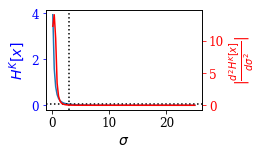

2.1003547496538397 0.03598357431427246


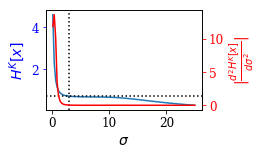

3.151930184862688 0.03358397839948077


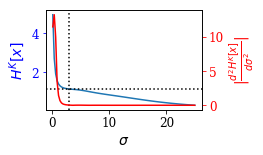

4.241026689501911 0.04632089312458299


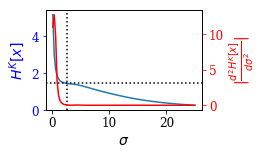

5.263443949972749 0.044285700358920856


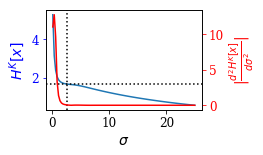

5.765941098147919 0.0450875286198368


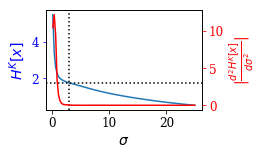

6.80233551456485 0.04556146471295166


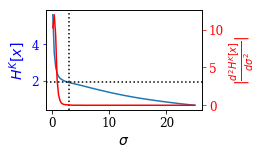

7.736059713521179 0.04437379782354559


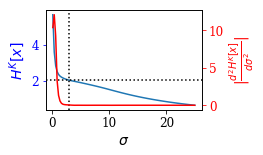

8.843928077389089 0.039906738146691795


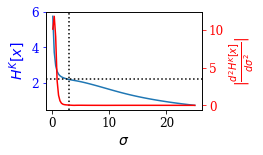

9.584551450288116 0.04413730088642466


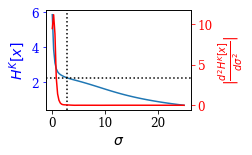

10.848877028319096 0.04900951467866489


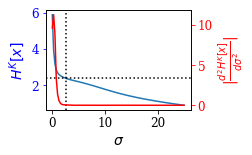

11.635605688194158 0.04272679923355603


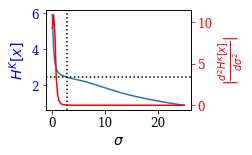

12.973671062595393 0.04539516308186862


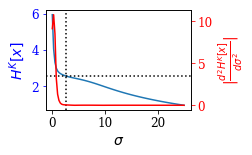

13.966532244666855 0.04706571714368294


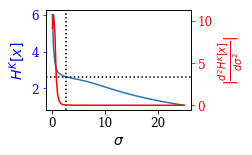

15.031451283590675 0.049968693491370494


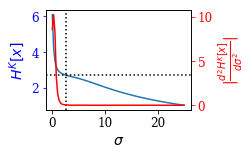

In [866]:
entropy_estimates, birthday_estimates, samples = progressive_plot(norm_means, norm_covs, n=1000)

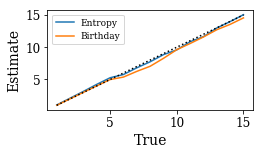

In [867]:

plt.figure(figsize=(4, 2.5))
plt.plot(np.arange(1, len(samples)+1), entropy_estimates, label="Entropy")
plt.plot(np.arange(1, len(samples)+1), birthday_estimates, label="Birthday")
plt.legend()
plt.xlabel("True")
plt.ylabel("Estimate")
#     plt.title("Estimates of number of modes")
plt.plot(np.arange(1, len(samples)+1), np.arange(1, len(samples)+1), linestyle=":", c="k", label="y=x")
plt.tight_layout()
plt.savefig("progressive_mode_detection.pdf")
plt.show()

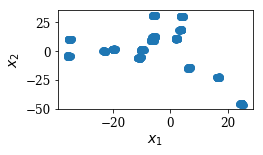

In [870]:
plt.figure(figsize=(4, 2.5))
plt.scatter(data[:, 0], data[:, 1])
# plt.title("Mixture of Gaussians")
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.tight_layout()
plt.savefig("big_mixture.pdf")
plt.show()

In [622]:
gmm_pdists = utils.batch_pdist(torch.tensor(data), torch.tensor(data), 1).float()

In [626]:
sigmas = np.linspace(.5, 15, 100)
# sigmas = np.exp(ks)
entropies = []
for sigma in sigmas:
    k = rbf_kernel_pdist(gmm_pdists, sigmas=[sigma], degree=10)
#     k = 1 / (1 + pdists/sigma)**2
    entropy = renyi_sim_entropy(k, torch.ones(k.shape[0])/k.shape[0]).item()
    entropies.append(entropy)

In [624]:
eps = np.linspace(1, 15, 100)
gmm_counts = []
alpha = 1
for j, cutoff in enumerate(eps):
#     k = rbf_kernel_pdist(pdists, sigmas=[sigma], degree=2)
    gmm_count = birthday(gmm_pdists, eps=cutoff)
    gmm_counts.append(gmm_count)

38.255340576171875
34.7381591796875
32.59592819213867
31.344125747680664
30.623504638671875
30.215959548950195
30.001802444458008
29.883338928222656
29.831581115722656
29.792436599731445
29.776453018188477
29.767581939697266
29.75339698791504
29.726835250854492
29.68267250061035
29.64215850830078
29.589479446411133
29.496870040893555
29.38926887512207
29.24815559387207
29.098217010498047
28.896217346191406
28.63448715209961
28.30188751220703
27.964393615722656
27.538867950439453
27.12315559387207
26.56773567199707
26.0278263092041
25.427610397338867
24.803852081298828
24.15143585205078
23.49372100830078
22.853092193603516
22.16551971435547
21.555259704589844
20.94251823425293
20.36033058166504
19.792367935180664
19.27083396911621
18.740150451660156
18.215965270996094
17.73477554321289
17.22117042541504
16.719104766845703
16.241262435913086
15.76008129119873
15.280837059020996
14.77417278289795
14.291028022766113
13.816662788391113
13.339920997619629
12.839296340942383
12.39146614074707

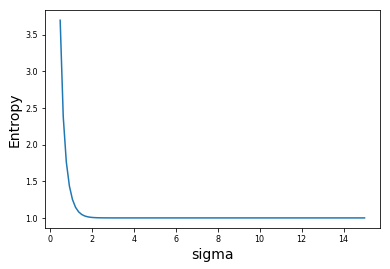

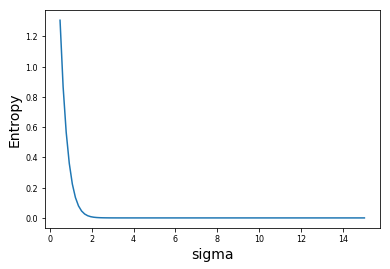

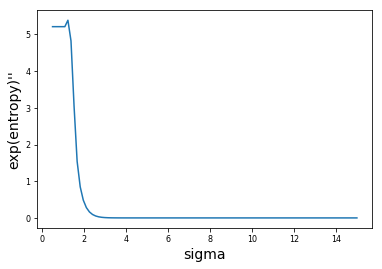

In [595]:
plt.figure()
plt.plot(sigmas, np.exp(entropies))
plt.xlabel("sigma")
plt.ylabel("Entropy")
plt.show()

plt.figure()
plt.plot(sigmas, (entropies))
plt.xlabel("sigma")
plt.ylabel("Entropy")
plt.show()


plt.figure()
plt.plot(sigmas, derivative(np.exp(entropies), sigmas[1]-sigmas[0], 2))
plt.xlabel("sigma")
plt.ylabel("exp(entropy)\'\'")
plt.show()

29.42745161437419


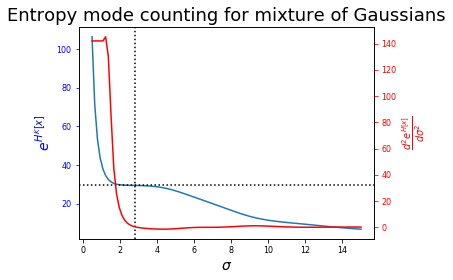

In [627]:
first_below_thresh = np.arange(len(entropies))[derivative(np.exp(entropies), sigmas[1]-sigmas[0], 2) < .5][0]
vertical = sigmas[first_below_thresh]
estimated_count = np.exp(entropies)[first_below_thresh]
print(estimated_count)

fig, ax1 = plt.subplots()
# t = np.arange(0.01, 10.0, 0.01)
# s1 = np.exp(t)
ax1.plot(sigmas, np.exp(entropies), label=r"$e^{H^K[x]}$")
ax1.set_xlabel(r'$\sigma$')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel(r"$e^{H^K[x]}$", color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
# s2 = np.sin(2 * np.pi * t)
ax2.plot(sigmas, derivative(np.exp(entropies), sigmas[1]-sigmas[0], 2), label=r"$\frac{d^2 e^{H[x]}}{d \sigma ^2}$", c="r")
ax2.set_ylabel(r"$\frac{d^2 e^{H[x]}}{d \sigma ^2}$", color='r',)
ax2.tick_params('y', colors='r')

ax1.axhline(estimated_count, color="k", linestyle=":")
ax1.axvline(vertical, color="k", linestyle=":")
# ax2.axhline(0.01, color="k", linestyle=":")
fig.tight_layout()
plt.title("Entropy mode counting for mixture of Gaussians")
plt.savefig("mog_detection.pdf")
plt.show()

In [514]:
eps = np.linspace(1, 15, 100)
gmm_counts = []
alpha = 1
for j, cutoff in enumerate(eps):
#     k = rbf_kernel_pdist(pdists, sigmas=[sigma], degree=2)
    gmm_count = birthday(gmm_pdists, eps=cutoff)
    print(gmm_count)
    gmm_counts.append(gmm_count)

129.74024963378906
102.16812896728516
82.73977661132812
69.15409088134766
58.92414855957031
50.74672317504883
44.68998718261719
39.91529846191406
36.13804244995117
32.98771667480469
30.457317352294922
28.265050888061523
26.435564041137695
24.84827423095703
23.516948699951172
22.329011917114258
21.33976936340332
20.47298812866211
19.65529441833496
18.951322555541992
18.35249900817871
17.826553344726562
17.33171272277832
16.871580123901367
16.446067810058594
16.064191818237305
15.733770370483398
15.369231224060059
15.050620079040527
14.757148742675781
14.487079620361328
14.225095748901367
13.966558456420898
13.7289400100708
13.49416446685791
13.258831977844238
13.05063533782959
12.820842742919922
12.604723930358887
12.374275207519531
12.163050651550293
11.94690227508545
11.744098663330078
11.555545806884766
11.371397018432617
11.17874813079834
11.006081581115723
10.840079307556152
10.648050308227539
10.475431442260742
10.3023681640625
10.126710891723633
9.957935333251953
9.77935218811035

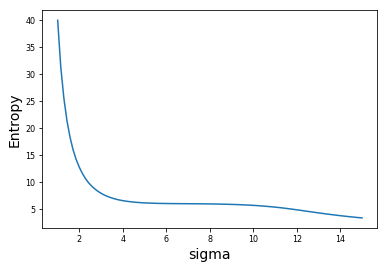

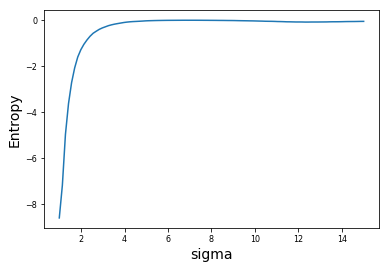

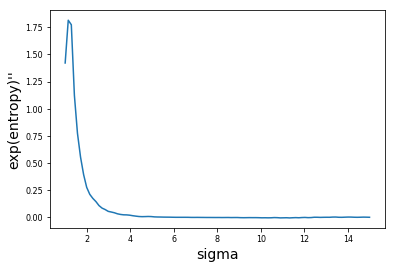

In [105]:
plt.figure()
plt.plot(sigmas, gmm_counts)
plt.xlabel("sigma")
plt.ylabel("Entropy")
plt.show()

plt.figure()
plt.plot(sigmas, np.gradient(gmm_counts))
plt.xlabel("sigma")
plt.ylabel("Entropy")
plt.show()


plt.figure()
plt.plot(sigmas, np.gradient(np.gradient(gmm_counts)))
plt.xlabel("sigma")
plt.ylabel("exp(entropy)\'\'")
plt.show()

38.255340576171875


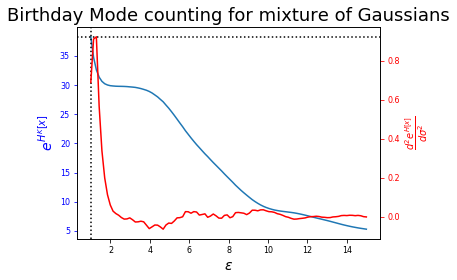

In [625]:
first_below_thresh = np.arange(len(entropies))[np.gradient(np.gradient(gmm_counts)) < 1.][0]
vertical = eps[first_below_thresh]
estimated_count = gmm_counts[first_below_thresh]
print(estimated_count)

fig, ax1 = plt.subplots()
# t = np.arange(0.01, 10.0, 0.01)
# s1 = np.exp(t)
ax1.plot(eps, gmm_counts, label=r"$e^{H^K[x]}$")
ax1.set_xlabel(r'$\epsilon$')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel(r"$e^{H^K[x]}$", color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
# s2 = np.sin(2 * np.pi * t)
ax2.plot(eps, np.gradient(np.gradient(gmm_counts)), label=r"$\frac{d^2 e^{H[x]}}{d \sigma ^2}$", c="r")
ax2.set_ylabel(r"$\frac{d^2 e^{H[x]}}{d \sigma ^2}$", color='r',)
ax2.tick_params('y', colors='r')

ax1.axhline(estimated_count, color="k", linestyle=":")
ax1.axvline(vertical, color="k", linestyle=":")
# ax2.axhline(0.01, color="k", linestyle=":")
fig.tight_layout()
plt.title("Birthday Mode counting for mixture of Gaussians")
plt.savefig("mog_detection.pdf")
plt.show()

## GAN Eval

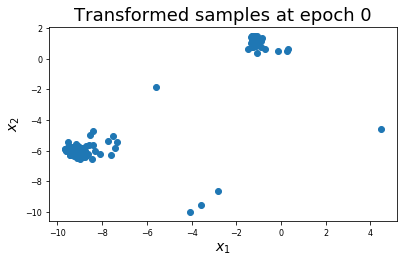

1.408080205905949


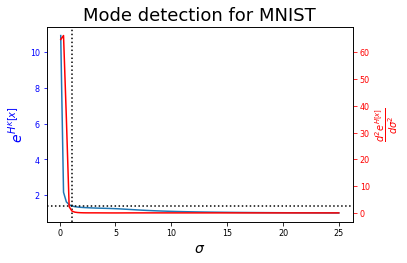

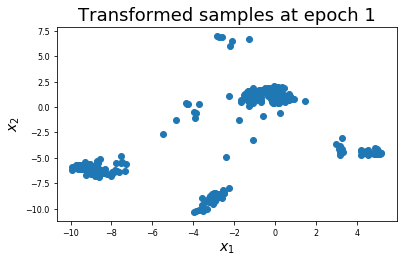

3.1798954262497827


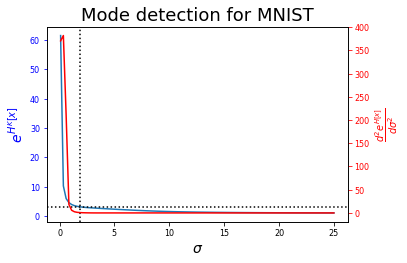

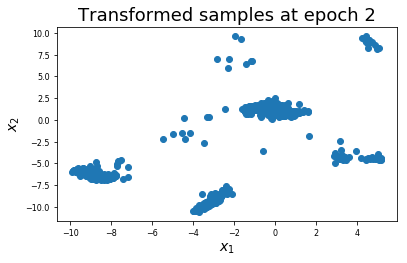

4.2095806241920695


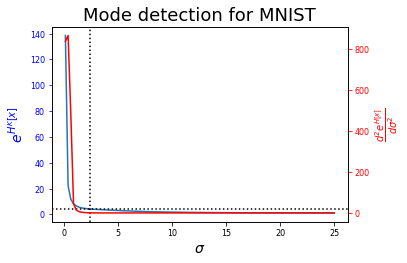

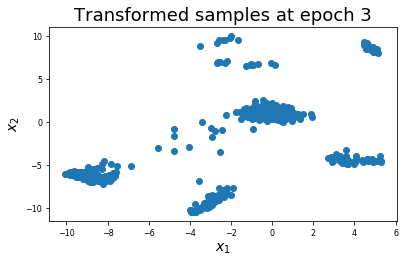

4.478811941183252


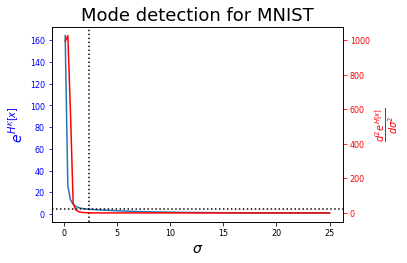

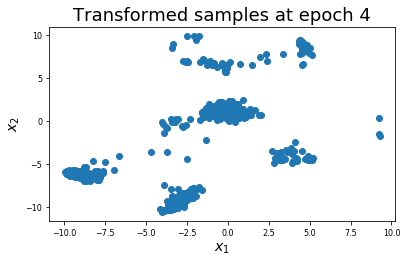

5.224105547100169


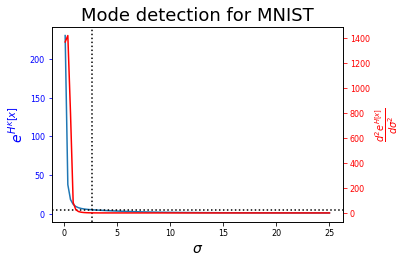

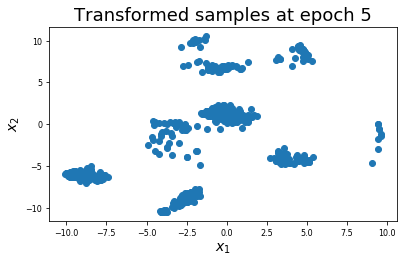

5.890907625861065


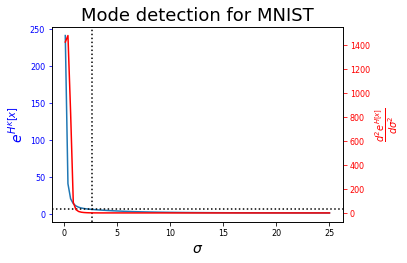

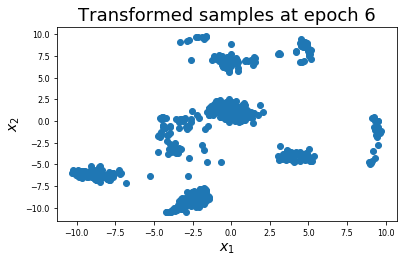

6.72318929376907


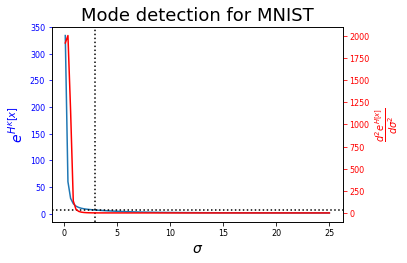

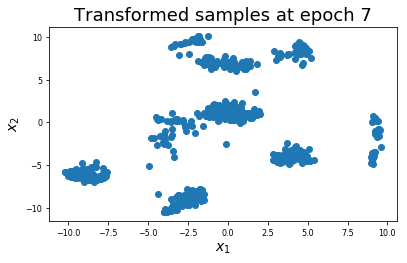

6.9171054368834


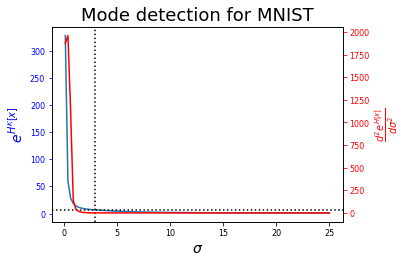

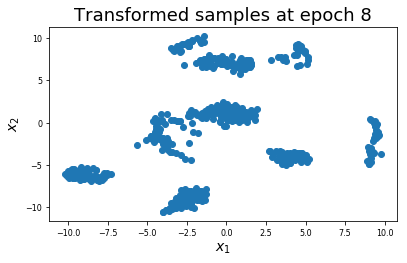

7.420723165243633


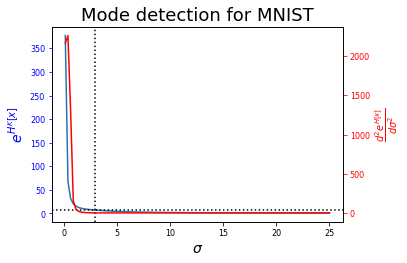

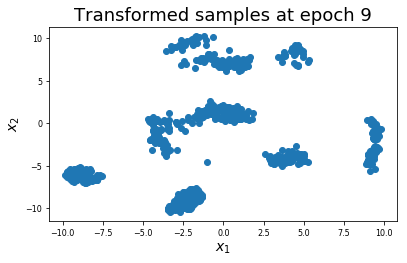

8.41492595621013


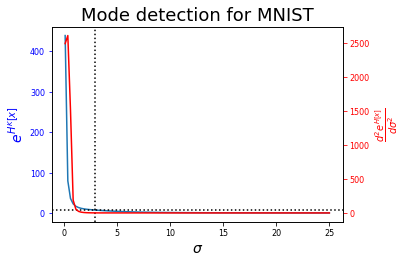

In [461]:
magnitudes = []
all_entropies = []
for i in range(10):
    flat_data_1 = np.load("Z:\Github\metric_it\gan_entropy_eval\logs\cnn_test\samples_{}.npz".format(i))["samples"]
    flat_data_1 = np.reshape(flat_data_1, (flat_data_1.shape[0], -1))
    umap_data_1 = reducer.transform(flat_data_1)
    plt.figure()
    plt.scatter(umap_data_1[:1000, 0], umap_data_1[:1000, 1])
    plt.title("Transformed samples at epoch {}".format(i))
    plt.xlabel(r"$x_1$")
    plt.ylabel(r"$x_2$")
    plt.tight_layout()
    plt.savefig("reduced_mnist.pdf")
    plt.show()
    umap_data_1 = torch.tensor(umap_data_1)
    pdists_1 = batch_pdist(umap_data_1, umap_data_1, 2)
    sigmas = np.linspace(.1, 25, 100)
    entropies = []
    alpha = 1
    for j, sigma in enumerate(sigmas):
        k = rbf_kernel_pdist(pdists_1, sigmas=[sigma], degree=2)
        entropy = renyi_sim_entropy(k, torch.ones(k.shape[0])/k.shape[0], alpha=alpha).item()
        entropies.append(entropy)
    
    d1 = np.abs(derivative(np.exp(entropies), sigmas[1]-sigmas[0], 1, smooth=False))
    d2 = derivative(np.exp(entropies), sigmas[1]-sigmas[0], 2, smooth=False)
    converged = (d2 < 1.)*\
            (d1 < 10)

#     print(np.exp(entropies))
    first_below_thresh = np.arange(len(entropies))[converged][0]
    vertical = sigmas[first_below_thresh]
    estimated_count = np.exp(entropies)[first_below_thresh]
    print(estimated_count)
    magnitudes.append(estimated_count)
    all_entropies.append(entropies)

    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1.plot(sigmas, np.exp(entropies), label=r"$e^{H^K[x]}$")
    ax1.set_xlabel(r'$\sigma$')
    ax1.set_ylabel(r"$e^{H^K[x]}$", color='b')
    ax1.tick_params('y', colors='b')

    ax2.plot(sigmas, d2, label=r"$\frac{d^2 e^{H[x]}}{d \sigma ^2}$", c="r")
    ax2.set_ylabel(r"$\frac{d^2 e^{H[x]}}{d \sigma ^2}$", color='r',)
    ax2.tick_params('y', colors='r')

    ax1.axhline(estimated_count, color="k", linestyle=":")
    ax1.axvline(vertical, color="k", linestyle=":")
    plt.title("Mode detection for MNIST")
    fig.tight_layout()
    plt.savefig("mnist_detection.pdf")
    plt.show()

In [478]:
cm(255)

(0.705673158, 0.01555616, 0.150232812, 1.0)

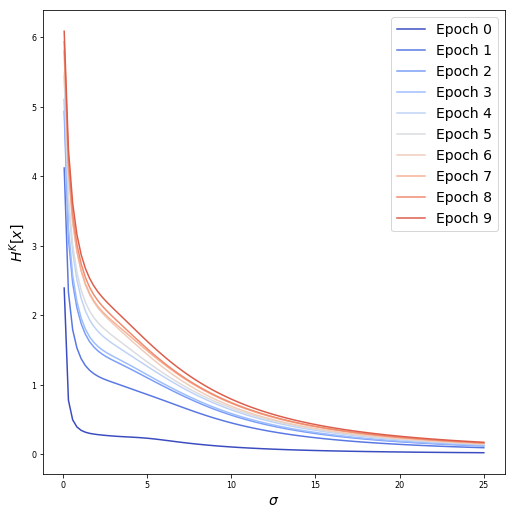

In [492]:
plt.figure(figsize=(7.5,7.5))
cm = matplotlib.cm.get_cmap("coolwarm")
for i, entropies in enumerate(all_entropies):
    color = cm(i*25)
    plt.plot(sigmas[0:], entropies[0:], label="Epoch {}".format(i), c=color)
    
plt.legend()
plt.xlabel(r"$\sigma$")
plt.ylabel(r"$H^K[x]$")
plt.tight_layout()
plt.savefig("Entropy_curves_over_time.pdf")
plt.show()

In [428]:
flat_data_1 = np.load("samples_5.npz")["samples"]
flat_data_2 = np.load("samples_500.npz")["samples"]

In [429]:
# reducer = UMAP(n_components=2, min_dist=0.001, metric="cosine")
umap_data_1 = reducer.transform(flat_data_1)
umap_data_2 = reducer.transform(flat_data_2)#reducer.fit_transform(flat_data[:])

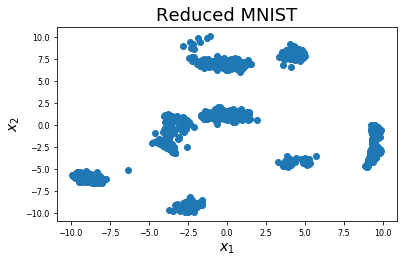

In [430]:
plt.figure()
plt.scatter(umap_data_1[:1000, 0], umap_data_1[:1000, 1])
plt.title("Reduced MNIST")
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.tight_layout()
plt.savefig("reduced_mnist.pdf")
plt.show()

In [431]:
umap_data_1 = torch.tensor(umap_data_1)
umap_data_2 = torch.tensor(umap_data_2)

In [432]:
pdists_1 = batch_pdist(umap_data_1[:1000], umap_data_1[:1000], 2)
pdists_2 = batch_pdist(umap_data_2[:1000], umap_data_2[:1000], 2)

In [433]:
all_entropies = []
for pdists in [pdists_1, pdists_2]:
    sigmas = np.linspace(1, 25, 100)
    entropies = []
    alpha = 1
    for j, sigma in enumerate(sigmas):
        k = rbf_kernel_pdist(pdists, sigmas=[sigma], degree=2)
        entropy = renyi_sim_entropy(k, torch.ones(k.shape[0])/k.shape[0], alpha=alpha).item()
        entropies.append(entropy)
    all_entropies.append(entropies)

In [434]:
all_counts = []
for pdists in [pdists_1, pdists_2]:
    eps = np.linspace(1, 25, 100)
    counts = []
    alpha = 1
    for j, sigma in enumerate(eps):
    #     k = rbf_kernel_pdist(pdists, sigmas=[sigma], degree=2)
        count = birthday(pdists, eps=sigma)
        counts.append(count)
    all_counts.append(counts)

### Plotting

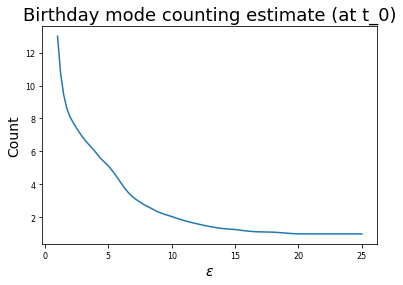

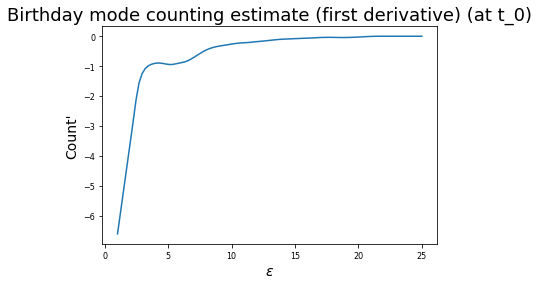

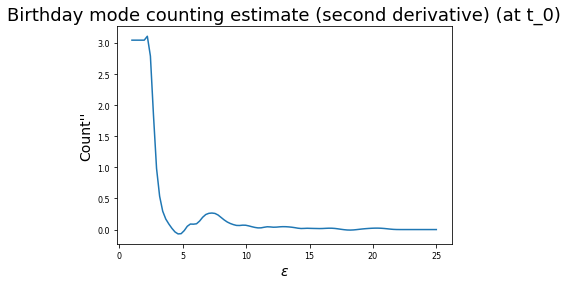

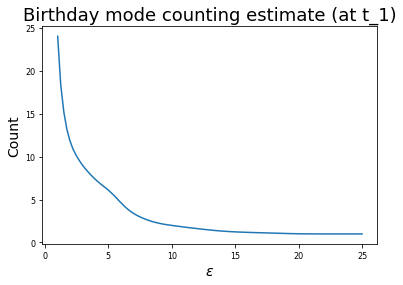

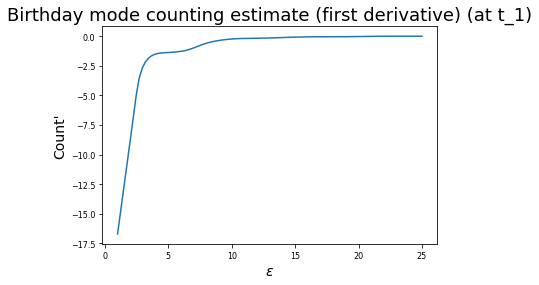

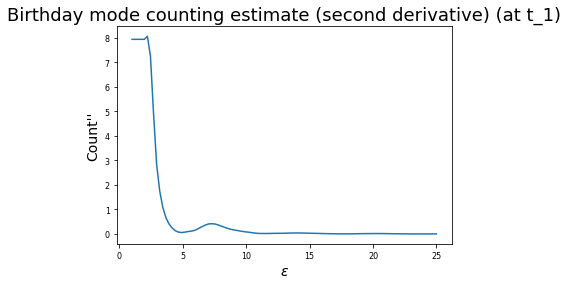

In [435]:
for i, counts in enumerate(all_counts):
    plt.figure()
    plt.plot(eps, counts, label="Birthday Estimate")
    # plt.yscale("log")
    plt.title("Birthday mode counting estimate (at t_{})".format(i))
    plt.xlabel(r"$\epsilon$")
    plt.ylabel("Count")
    plt.show()

    plt.figure()
    plt.plot(eps, derivative(counts, eps[1]-eps[0], 1), label="Birthday Estimate")
    # plt.yscale("log")
    plt.title("Birthday mode counting estimate (first derivative) (at t_{})".format(i))
    plt.xlabel(r"$\epsilon$")
    plt.ylabel("Count\'")
    plt.show()

    plt.figure()
    plt.plot(eps, derivative(counts, eps[1]-eps[0], 2), label="Birthday Estimate")
    # plt.yscale("log")
    plt.title("Birthday mode counting estimate (second derivative) (at t_{})".format(i))
    plt.xlabel(r"$\epsilon$")
    plt.ylabel("Count\'\'")
    plt.show()

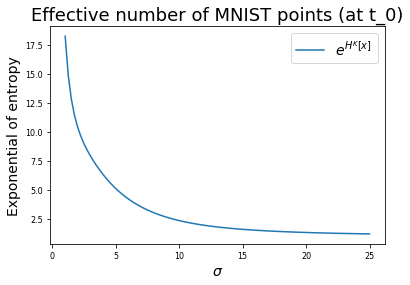

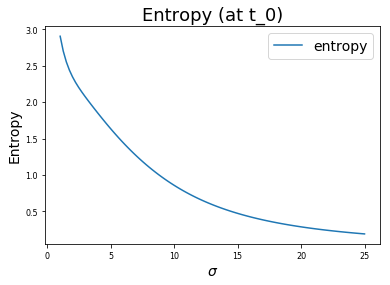

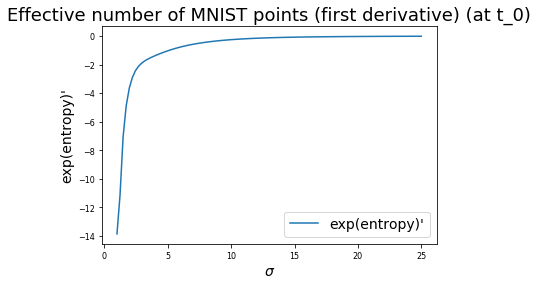

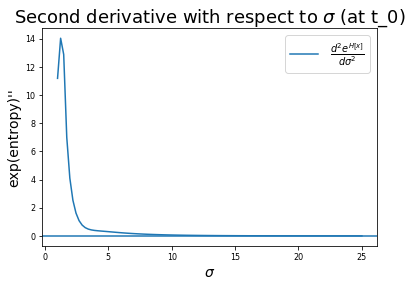

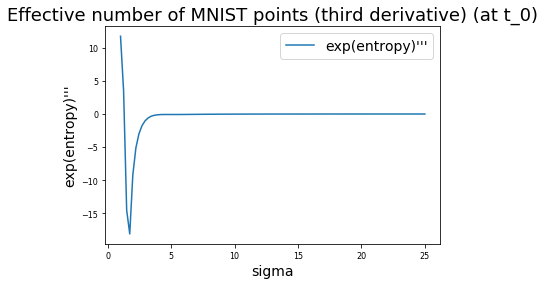

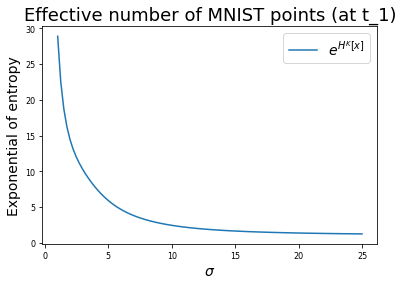

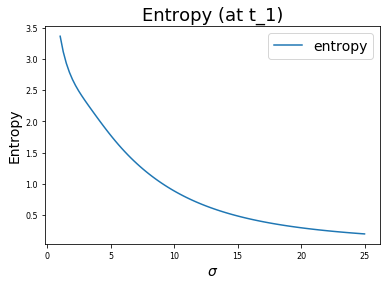

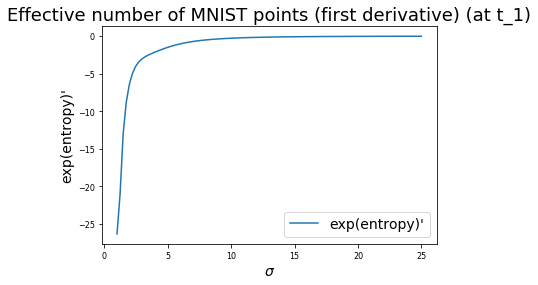

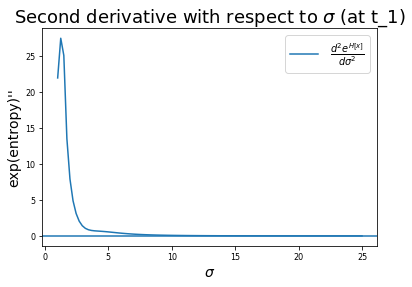

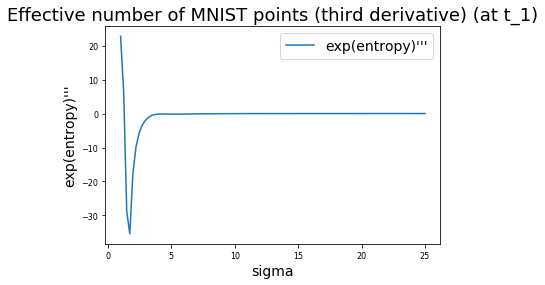

In [436]:
for i, entropies in enumerate(all_entropies):
    plt.figure()
    plt.plot(sigmas, np.exp(entropies), label=r"$e^{H^K[x]}$")
    plt.xlabel(r"$\sigma$")
    plt.ylabel("Exponential of entropy")
    # plt.axhline(10)
    plt.legend()
    plt.title("Effective number of MNIST points (at t_{})".format(i))
    # plt.xlim(10, 20)
    # plt.ylim(0, 4)
    plt.show()

    plt.figure()
    plt.plot(sigmas, entropies, label="entropy")
    plt.xlabel(r"$\sigma$")
    plt.ylabel("Entropy")
    plt.legend()
    plt.title("Entropy (at t_{})".format(i))
    # plt.xlim(10, 20)
    # plt.ylim(0, 4)
    plt.show()

    plt.figure()
    plt.plot(sigmas, derivative(np.exp(entropies), sigmas[1]-sigmas[0], 1, smooth=False), label="exp(entropy)\'")
    plt.xlabel(r"$\sigma$")
    plt.ylabel("exp(entropy)\'")
    plt.title("Effective number of MNIST points (first derivative) (at t_{})".format(i))
    plt.legend()
    # plt.xlim(10, 20)
    # plt.ylim(0, 4)
    plt.show()


    plt.figure()
    plt.plot(sigmas, derivative(np.exp(entropies), sigmas[1]-sigmas[0], 2, smooth=False), label=r"$\frac{d^2 e^{H[x]}}{d \sigma ^2}$")
    plt.xlabel(r"$\sigma$")
    plt.axhline(0)
    plt.ylabel("exp(entropy)\'\'")
    plt.title(r"Second derivative with respect to $\sigma$ (at t_{})".format(i))
    plt.legend()
    # plt.xlim(10, 20)
    # plt.ylim(0, 4)
    plt.show()

    plt.figure()
    plt.plot(sigmas, derivative(np.exp(entropies), sigmas[1]-sigmas[0], 3, smooth=False), label="exp(entropy)\'\'\'")
    plt.xlabel("sigma")
    plt.ylabel("exp(entropy)\'\'\'")
    plt.title("Effective number of MNIST points (third derivative) (at t_{})".format(i))
    plt.legend()
    # plt.xlim(10, 20)
    # plt.ylim(0, 4)
    plt.show()

8.027363784933785


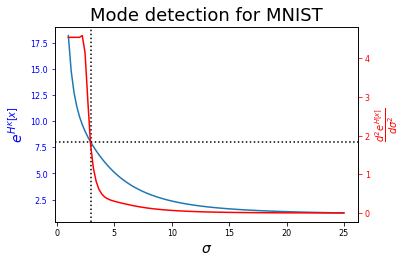

9.017142029386301


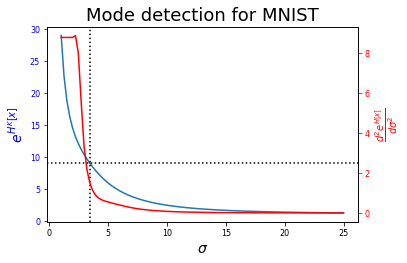

In [437]:
for i, entropies in enumerate(all_entropies):
    first_below_thresh = np.arange(len(entropies))[derivative(np.exp(entropies), sigmas[1]-sigmas[0], 2, smooth=False) < 1.][0]
    vertical = sigmas[first_below_thresh]
    estimated_count = np.exp(entropies)[first_below_thresh]
    print(estimated_count)

    fig, ax1 = plt.subplots()
    # t = np.arange(0.01, 10.0, 0.01)
    # s1 = np.exp(t)
    ax1.plot(sigmas, np.exp(entropies), label=r"$e^{H^K[x]}$")
    ax1.set_xlabel(r'$\sigma$')
    # Make the y-axis label, ticks and tick labels match the line color.
    ax1.set_ylabel(r"$e^{H^K[x]}$", color='b')
    ax1.tick_params('y', colors='b')

    ax2 = ax1.twinx()
    # s2 = np.sin(2 * np.pi * t)
    ax2.plot(sigmas, derivative(np.exp(entropies), sigmas[1]-sigmas[0], 2), label=r"$\frac{d^2 e^{H[x]}}{d \sigma ^2}$", c="r")
    ax2.set_ylabel(r"$\frac{d^2 e^{H[x]}}{d \sigma ^2}$", color='r',)
    ax2.tick_params('y', colors='r')

    ax1.axhline(estimated_count, color="k", linestyle=":")
    ax1.axvline(vertical, color="k", linestyle=":")
    # ax2.axhline(0.01, color="k", linestyle=":")
    plt.title("Mode detection for MNIST")
    fig.tight_layout()
    plt.savefig("mnist_detection.pdf")
    plt.show()

7.796525001525879


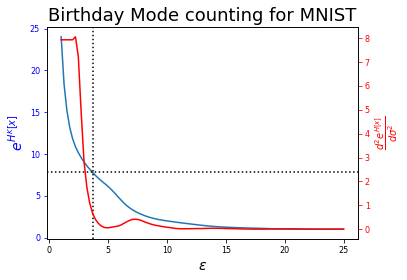

In [438]:
first_below_thresh = np.arange(len(counts))[derivative(counts, eps[1]-eps[0], 2) < 1.][0]
vertical = eps[first_below_thresh]
estimated_count = counts[first_below_thresh]
print(estimated_count)

fig, ax1 = plt.subplots()
# t = np.arange(0.01, 10.0, 0.01)
# s1 = np.exp(t)
ax1.plot(eps, counts, label=r"$e^{H^K[x]}$")
ax1.set_xlabel(r'$\epsilon$')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel(r"$e^{H^K[x]}$", color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
# s2 = np.sin(2 * np.pi * t)
ax2.plot(eps, derivative(counts, eps[1]-eps[0], 2), label=r"$\frac{d^2 e^{H[x]}}{d \sigma ^2}$", c="r")
ax2.set_ylabel(r"$\frac{d^2 e^{H[x]}}{d \sigma ^2}$", color='r',)
ax2.tick_params('y', colors='r')

ax1.axhline(estimated_count, color="k", linestyle=":")
ax1.axvline(vertical, color="k", linestyle=":")
# ax2.axhline(0.01, color="k", linestyle=":")
fig.tight_layout()
plt.title("Birthday Mode counting for MNIST")
plt.savefig("mog_detection.pdf")
plt.show()

9.017142029386301


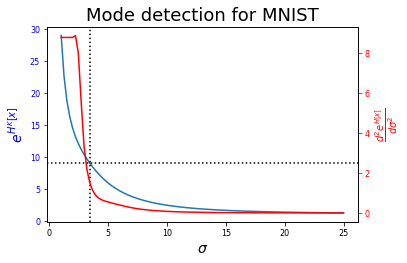

In [439]:
converged = (derivative(np.exp(entropies), sigmas[1]-sigmas[0], 2, smooth=False) < 1.)*\
            (np.abs(derivative(np.exp(entropies), sigmas[1]-sigmas[0], 1, smooth=False)) < 5)

first_below_thresh = np.arange(len(entropies))[converged][0]
vertical = sigmas[first_below_thresh]
estimated_count = np.exp(entropies)[first_below_thresh]
print(estimated_count)

fig, ax1 = plt.subplots()
# t = np.arange(0.01, 10.0, 0.01)
# s1 = np.exp(t)
ax1.plot(sigmas, np.exp(entropies), label=r"$e^{H^K[x]}$")
ax1.set_xlabel(r'$\sigma$')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel(r"$e^{H^K[x]}$", color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
# s2 = np.sin(2 * np.pi * t)
ax2.plot(sigmas, (derivative(np.exp(entropies), sigmas[1]-sigmas[0], 2)), label=r"$\frac{d^2 e^{H[x]}}{d \sigma ^2}$", c="r")
ax2.set_ylabel(r"$\frac{d^2 e^{H[x]}}{d \sigma ^2}$", color='r',)
ax2.tick_params('y', colors='r')

ax1.axhline(estimated_count, color="k", linestyle=":")
ax1.axvline(vertical, color="k", linestyle=":")
# ax2.axhline(0.01, color="k", linestyle=":")
plt.title("Mode detection for MNIST")
fig.tight_layout()
plt.savefig("mnist_detection.pdf")
plt.show()

3.3186943531036377


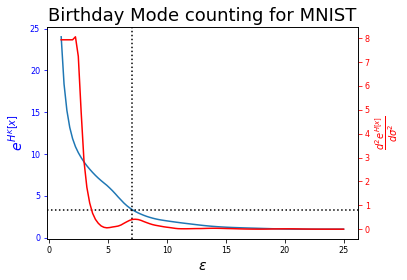

In [440]:
converged = (derivative(counts, eps[1]-eps[0], 2) < 1.)*\
            (np.abs(derivative(counts, eps[1]-eps[0], 1)) < 1)

first_below_thresh = np.arange(len(counts))[converged][0]
vertical = eps[first_below_thresh]
estimated_count = counts[first_below_thresh]
print(estimated_count)
fig, ax1 = plt.subplots()
# t = np.arange(0.01, 10.0, 0.01)
# s1 = np.exp(t)
ax1.plot(eps, counts, label=r"$e^{H^K[x]}$")
ax1.set_xlabel(r'$\epsilon$')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel(r"$e^{H^K[x]}$", color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
# s2 = np.sin(2 * np.pi * t)
ax2.plot(eps, derivative(counts, eps[1]-eps[0], 2), label=r"$\frac{d^2 e^{H[x]}}{d \sigma ^2}$", c="r")
ax2.set_ylabel(r"$\frac{d^2 e^{H[x]}}{d \sigma ^2}$", color='r',)
ax2.tick_params('y', colors='r')

ax1.axhline(estimated_count, color="k", linestyle=":")
ax1.axvline(vertical, color="k", linestyle=":")
# ax2.axhline(0.01, color="k", linestyle=":")
fig.tight_layout()
plt.title("Birthday Mode counting for MNIST")
plt.savefig("mog_detection.pdf")
plt.show()

## CIFAR10

In [736]:
reader = ImageReader("./data", "cifar")

Files already downloaded and verified


In [674]:
iterator = reader.iter_batches("train", 100000, partial_batching=True)
data = []
for batch in iterator:
    data.append(batch)
labels = data[0][1]
data = data[0][0]
flat_data = data.flatten(1, -1).numpy()

In [675]:
reducer = UMAP(n_components=2, min_dist=0.001, metric="cosine")
umap_data = reducer.fit_transform(flat_data[:])

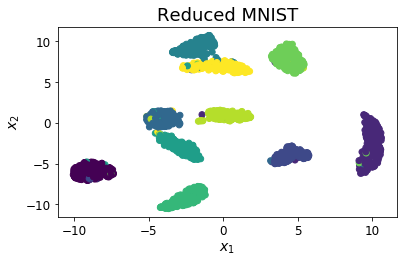

In [681]:
plt.figure()
plt.scatter(umap_data[:2000, 0], umap_data[:2000, 1], c=labels[:2000])
plt.title("Reduced MNIST")
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.tight_layout()
plt.savefig("reduced_mnist.pdf")
plt.show()

In [677]:
umap_data = torch.tensor(umap_data)

In [678]:
pdists = batch_pdist(umap_data[:1000], umap_data[:1000], 2)
raw_pdists = batch_pdist(torch.tensor(flat_data[:1000]), torch.tensor(flat_data[:1000]), 1)

In [679]:
sigmas = np.linspace(1, 10, 100)
entropies = []
alpha = 1
for j, sigma in enumerate(sigmas):
    k = rbf_kernel_pdist(pdists, sigmas=[sigma], degree=2)
    entropy = renyi_sim_entropy(k, torch.ones(k.shape[0])/k.shape[0], alpha=alpha).item()
    entropies.append(entropy)

In [680]:
eps = np.linspace(1., 10, 100)
counts = []
alpha = 1
for j, sigma in enumerate(eps):
#     k = rbf_kernel_pdist(pdists, sigmas=[sigma], degree=2)
    count = birthday(pdists, eps=sigma)
    counts.append(count)

### Plotting

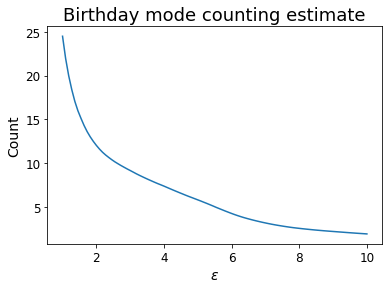

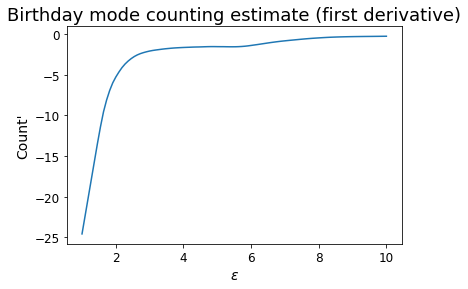

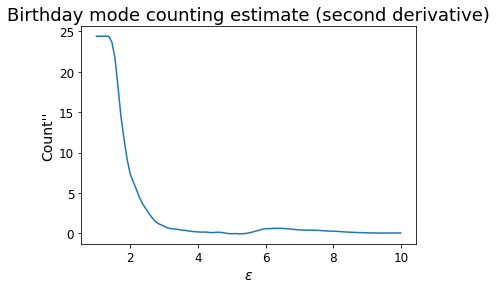

In [682]:
plt.figure()
plt.plot(eps, counts, label="Birthday Estimate")
# plt.yscale("log")
plt.title("Birthday mode counting estimate")
plt.xlabel(r"$\epsilon$")
plt.ylabel("Count")
plt.show()

plt.figure()
plt.plot(eps, derivative(counts, eps[1]-eps[0], 1), label="Birthday Estimate")
# plt.yscale("log")
plt.title("Birthday mode counting estimate (first derivative)")
plt.xlabel(r"$\epsilon$")
plt.ylabel("Count\'")
plt.show()

plt.figure()
plt.plot(eps, derivative(counts, eps[1]-eps[0], 2), label="Birthday Estimate")
# plt.yscale("log")
plt.title("Birthday mode counting estimate (second derivative)")
plt.xlabel(r"$\epsilon$")
plt.ylabel("Count\'\'")
plt.show()

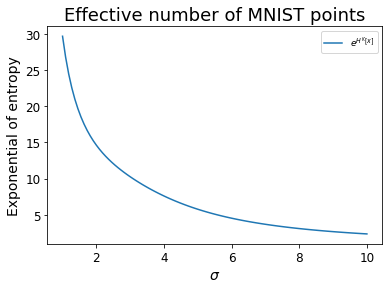

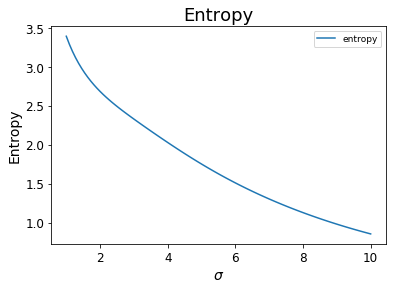

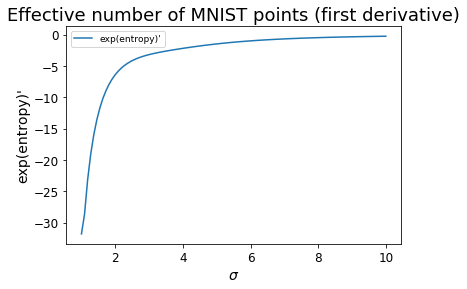

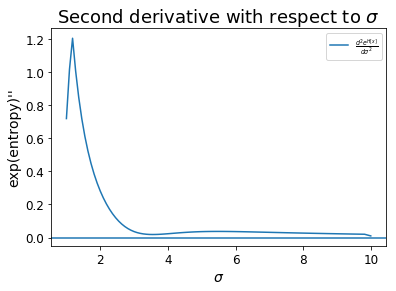

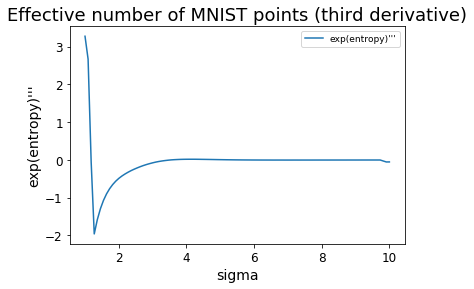

In [692]:
plt.figure()
plt.plot(sigmas, np.exp(entropies), label=r"$e^{H^K[x]}$")
plt.xlabel(r"$\sigma$")
plt.ylabel("Exponential of entropy")
# plt.axhline(10)
plt.legend()
plt.title("Effective number of MNIST points")
# plt.xlim(10, 20)
# plt.ylim(0, 4)
plt.show()

plt.figure()
plt.plot(sigmas, entropies, label="entropy")
plt.xlabel(r"$\sigma$")
plt.ylabel("Entropy")
plt.legend()
plt.title("Entropy")
# plt.xlim(10, 20)
# plt.ylim(0, 4)
plt.show()

plt.figure()
plt.plot(sigmas, derivative(np.exp(entropies), sigmas[1]-sigmas[0], 1, smooth=False), label="exp(entropy)\'")
plt.xlabel(r"$\sigma$")
plt.ylabel("exp(entropy)\'")
plt.title("Effective number of MNIST points (first derivative)")
plt.legend()
# plt.xlim(10, 20)
# plt.ylim(0, 4)
plt.show()


plt.figure()
plt.plot(sigmas, derivative((entropies), sigmas[1]-sigmas[0], 2, smooth=False), label=r"$\frac{d^2 e^{H[x]}}{d \sigma ^2}$")
plt.xlabel(r"$\sigma$")
plt.axhline(0)
plt.ylabel("exp(entropy)\'\'")
plt.title(r"Second derivative with respect to $\sigma$")
plt.legend()
# plt.xlim(10, 20)
# plt.ylim(0, 4)
plt.show()



plt.figure()
plt.plot(sigmas, derivative((entropies), sigmas[1]-sigmas[0], 3, smooth=False), label="exp(entropy)\'\'\'")
plt.xlabel("sigma")
plt.ylabel("exp(entropy)\'\'\'")
plt.title("Effective number of MNIST points (third derivative)")
plt.legend()
# plt.xlim(10, 20)
# plt.ylim(0, 4)
plt.show()

In [308]:
derivative(np.exp(entropies), sigmas[1]-sigmas[0], 2, smooth=False)

array([3.45419358e+01, 4.73093520e+01, 5.24630706e+01, 3.95300049e+01,
       3.03954948e+01, 2.37799399e+01, 1.88803586e+01, 1.51794282e+01,
       1.23359703e+01, 1.01166837e+01, 8.35930511e+00, 6.95194362e+00,
       5.81275789e+00, 4.88295199e+00, 4.12081953e+00, 3.49227391e+00,
       2.97363731e+00, 2.54699361e+00, 2.19622809e+00, 1.90910719e+00,
       1.67617668e+00, 1.48853405e+00, 1.33735427e+00, 1.21673553e+00,
       1.12228880e+00, 1.04783388e+00, 9.88997436e-01, 9.43120935e-01,
       9.06661294e-01, 8.77403289e-01, 8.53455863e-01, 8.32852148e-01,
       8.14509211e-01, 7.97468172e-01, 7.81051677e-01, 7.64718180e-01,
       7.48093220e-01, 7.30947786e-01, 7.13172853e-01, 6.94897936e-01,
       6.76039427e-01, 6.56610480e-01, 6.36948128e-01, 6.16946292e-01,
       5.96609574e-01, 5.76419010e-01, 5.56292079e-01, 5.36215079e-01,
       5.16393285e-01, 4.96995916e-01, 4.78020792e-01, 4.59381587e-01,
       4.41294478e-01, 4.23802083e-01, 4.06883795e-01, 3.90508916e-01,
      

9.692462062145955


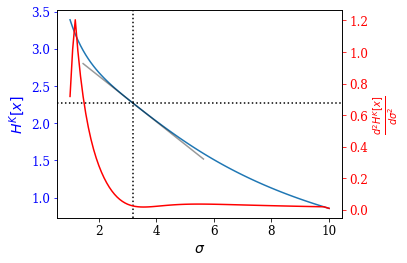

In [731]:
first_below_thresh = np.arange(len(entropies))[np.abs(derivative((entropies),
                                                                 sigmas[1]-sigmas[0], 3, smooth=False)) < .05][0]
vertical = sigmas[first_below_thresh]
estimated_count = (entropies)[first_below_thresh]
print(np.exp(estimated_count))

line_y = sigmas*derivative((entropies), sigmas[1]-sigmas[0], 1, smooth=False)[first_below_thresh]
line_y = line_y - line_y[first_below_thresh] + (entropies)[first_below_thresh]

fig, ax1 = plt.subplots()
# t = np.arange(0.01, 10.0, 0.01)
# s1 = np.exp(t)
ax1.plot(sigmas, (entropies), label=r"$e^{H^K[x]}$")
ax1.set_xlabel(r'$\sigma$')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel(r"$H^K[x]$", color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
# s2 = np.sin(2 * np.pi * t)
ax2.plot(sigmas, derivative((entropies), sigmas[1]-sigmas[0], 2, smooth=False), label=r"$\frac{d^2 e^{H[x]}}{d \sigma ^2}$", c="r")
ax2.set_ylabel(r"$\frac{d^2 H^K[x]}{d \sigma ^2}$", color='r',)
ax2.tick_params('y', colors='r')

ax1.plot(sigmas[5:52], line_y[5:52], c="k", linestyle="-", alpha=0.4)

ax1.axhline(estimated_count, color="k", linestyle=":")
ax1.axvline(vertical, color="k", linestyle=":")
# ax2.axhline(0.01, color="k", linestyle=":")
# plt.title("Mode detection for MNIST")
fig.tight_layout()
plt.savefig("mnist_detection.pdf")
plt.show()

9.132963180541992


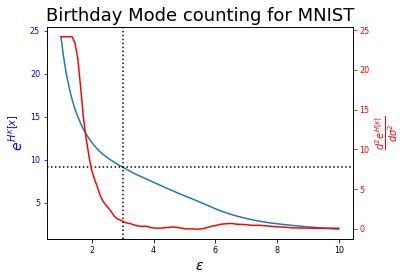

In [313]:
first_below_thresh = np.arange(len(counts))[derivative(counts, eps[1]-eps[0], 2) < 1.][0]
vertical = eps[first_below_thresh]
estimated_count = counts[first_below_thresh]
print(estimated_count)

fig, ax1 = plt.subplots()
# t = np.arange(0.01, 10.0, 0.01)
# s1 = np.exp(t)
ax1.plot(eps, counts, label=r"$e^{H^K[x]}$")
ax1.set_xlabel(r'$\epsilon$')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel(r"$e^{H^K[x]}$", color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
# s2 = np.sin(2 * np.pi * t)
ax2.plot(eps, derivative(counts, eps[1]-eps[0], 2), label=r"$\frac{d^2 e^{H[x]}}{d \sigma ^2}$", c="r")
ax2.set_ylabel(r"$\frac{d^2 e^{H[x]}}{d \sigma ^2}$", color='r',)
ax2.tick_params('y', colors='r')

ax1.axhline(estimated_count, color="k", linestyle=":")
ax1.axvline(vertical, color="k", linestyle=":")
# ax2.axhline(0.01, color="k", linestyle=":")
fig.tight_layout()
plt.title("Birthday Mode counting for MNIST")
plt.savefig("mog_detection.pdf")
plt.show()